In [112]:
import math
import numpy as np
import pandas as pd
import astropy.units as units
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy.stats import ks_2samp
from BASE9Analysis import readGaiaData
from BASE9Analysis import findSeparation

from matplotlib import font_manager
#point to font directory and find files within it
font_dirs = ['/Library/Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
#add fonts
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
# set font
plt.rcParams['font.family'] = 'Noto Sans JP'

%matplotlib inline

In [113]:
#read data from ecsv and round to 4 decimals
originalGaia=readGaiaData('M67data.ecsv')
originalGaia=originalGaia.round(4)

blue = '#F8766D'
purple = '#7CAE00'
pink = '#00BFC4'
gold = '#C77CFF'

# blue = '#0000ff'
# purple = '#aa54c2'
# pink = '#df9681'
# gold = '#ffd700'

In [ ]:
# from astropy import units,constants
# Rhmpc = (Rhm*units.m).to(units.pc)

In [114]:
#create dataframe for photometry, and define analysis columns
ph = "/Users/Claire/Documents/Code/current/ANNACRNN/NGC6819_FINAL/NGC_6819_final_2.df"
phot = pd.read_csv(ph, sep=' ')

#0.02 CMprior w/o anything?
#0.25 CMprior and qMedian filters
#0.1 CMprior and qMedian filters

phot = phot[phot['CMprior'] >= 0.12]
#store any single star, and store any binary with qMedian >= 0.5
phot = phot[((phot['binary'] == False)) | ((phot['binary'] == True) & (phot['qMedian'] >= 0.5))]

upperlim=14.85
lowerlim=19.5

phot_CMDcut = phot.loc[(phot['G'] > lowerlim) | (phot['G'] < upperlim)]
phot_CMDcutMems = phot_CMDcut[phot_CMDcut['member'] == True]
phot_CMDcutBinary = phot_CMDcut.loc[phot_CMDcut['binary'] == True]

phot = phot[phot['G'] > upperlim]
phot = phot[phot['G'] < lowerlim]

# phot = phot[phot['g_ps'] < 21]
#phot = phot[phot['sigG_BP'] < np.nanmedian(phot['sigG_BP'])]
#phot = phot[phot['m1Median'] > .6]


#phot = phot[phot['sigG_BP'] < 0.0075]
#phot = phot[phot['qMedian'] >= 0.1]

In [115]:
phot.columns

Index(['Unnamed: 0', 'source_id', 'ra', 'dec', 'pmra', 'pmdec',
       'radial_velocity', 'G', 'phot_g_mean_flux_over_error', 'G_BP',
       'phot_bp_mean_flux_over_error', 'G_RP', 'phot_rp_mean_flux_over_error',
       'parallax', 'teff_gspphot', 'ruwe', 'number_of_neighbours',
       'number_of_mates', 'g_ps', 'sigg_ps', 'r_ps', 'sigr_ps', 'i_ps',
       'sigi_ps', 'z_ps', 'sigz_ps', 'y_ps', 'sigy_ps', 'J_2M', 'sigJ_2M',
       'H_2M', 'sigH_2M', 'Ks_2M', 'sigKs_2M', 'sigG', 'sigG_BP', 'sigG_RP',
       'coord.ra', 'coord.dec', 'rCenter', 'id', 'PPa', 'sig_E(B-V)', 'E(B-V)',
       'PRV', 'PM_ra', 'PM_dec', 'PPM', 'CMprior', 'member', 'binary',
       'm1Median', 'qMedian', 'm1Std', 'm1_16', 'm1_84', 'qStd', 'q_16',
       'q_84'],
      dtype='object')

In [116]:
np.mean(phot['m1Median'])

1.0214662816728168

# Calculations

In [117]:
phot['distance'] = findSeparation(phot)
ten_core_radii = 29/60 #in degrees
phot = phot[phot['distance'] < ten_core_radii]

In [118]:
nBinary = 0
nCluster = 0
count = 0
for i, row in phot.iterrows():
    if row['member']:
        nCluster += 1
        
    if row['binary']:
            nBinary += 1

            if row['qMedian'] <= 0.5:
                count += 1
            
print(f"# Binaries: {nBinary}")
print(f"# Cluster objects: {nCluster}")
print(f"Binary Fraction: {nBinary/nCluster:.3f}")
print(f"Std: {np.sqrt(nBinary)/nCluster:.3f}")
print(f"q>=0.5 Binaries: {count}")
print(f"q>=0.5 binary fraction: {count/nCluster:.4f}")
print(f"q>=0.5 std: {np.sqrt(count)/nCluster:.3f}")

# Binaries: 288
# Cluster objects: 1275
Binary Fraction: 0.226
Std: 0.013
q>=0.5 Binaries: 0
q>=0.5 binary fraction: 0.0000
q>=0.5 std: 0.000


In [119]:
# Load the data from file
res_data = np.loadtxt('/Users/Claire/Documents/Code/current/ANNACRNN/NGC6819_FINAL/NGC_6819_final.res', skiprows=1, usecols=[0, 1, 2, 3, 5])
age_all, metallicity_all, distance_mod_all, reddening_all, stage = res_data.T

# Only use data from stage 3, and discard burn-in data
index = np.where(stage == 3)
distance_mod, reddening, age, metallicity = distance_mod_all[index], reddening_all[index], age_all[index], metallicity_all[index]

# Calculate statistics for distance modulus and reddening
distance_mod_mean, distance_mod_std = np.average(distance_mod), np.std(distance_mod)
reddening_mean, reddening_std = np.average(reddening), np.std(reddening)
age_mean, age_std = np.average(10**age)/(10**9), np.std(10**age)/(10**9)
metallicity_mean, metallicity_std = np.average(metallicity), np.std(metallicity)

# Format the output strings
distance_mod_string = f"{distance_mod_mean:.4f} \u00B1 {distance_mod_std:.4f}"
reddening_string = f"{reddening_mean:.4f} \u00B1 {reddening_std:.4f}"
age_string = f"{age_mean:.4f} \u00B1  {age_std:.4f}"
metallicity_string = f"{metallicity_mean:.4f} \u00B1  {metallicity_std:.4f}"

# Print the results
print(f"Distance Modulus: {distance_mod_string} (mag)")
print(f"Reddening: {reddening_string} (mmag)")
print(f"Age: {age_string} (Gyr)")
print(f"Metallicity: {metallicity_string} (dex)")

Distance Modulus: 12.4745 ± 0.0021 (mag)
Reddening: 0.5564 ± 0.0020 (mmag)
Age: 2.4275 ±  0.0045 (Gyr)
Metallicity: -0.0346 ±  0.0027 (dex)


In [120]:
#define a dataframe including photometric members
pd.options.mode.chained_assignment = None  # Disable the warning
photMems = phot.loc[phot['member']]
photMems['m2Median'] = photMems['m1Median'] * photMems['qMedian']
photMems_copy = photMems.copy()

In [121]:
#make separate dataframes for single stars and binaries, and make copies
singlePhot = photMems_copy.loc[photMems_copy['binary']== False]
binaryPhot = photMems_copy.loc[photMems_copy['binary']== True]
singlePhot_copy = singlePhot.copy()
binaryPhot_copy = binaryPhot.copy()

In [122]:
# photMems_copy['distance'] = findSeparation(photMems_copy)
# singlePhot_copy['distance'] = findSeparation(singlePhot_copy)
# binaryPhot_copy['distance'] = findSeparation(binaryPhot_copy)

# ten_core_radii = 29/60 #in degrees
# photMems_copy = photMems_copy[photMems_copy['distance'] < ten_core_radii ]
# singlePhot_copy = singlePhot_copy[singlePhot_copy['distance'] < ten_core_radii ]
# binaryPhot_copy = binaryPhot_copy[binaryPhot_copy['distance'] < ten_core_radii ]

In [123]:
binaryPhot_copy.columns

Index(['Unnamed: 0', 'source_id', 'ra', 'dec', 'pmra', 'pmdec',
       'radial_velocity', 'G', 'phot_g_mean_flux_over_error', 'G_BP',
       'phot_bp_mean_flux_over_error', 'G_RP', 'phot_rp_mean_flux_over_error',
       'parallax', 'teff_gspphot', 'ruwe', 'number_of_neighbours',
       'number_of_mates', 'g_ps', 'sigg_ps', 'r_ps', 'sigr_ps', 'i_ps',
       'sigi_ps', 'z_ps', 'sigz_ps', 'y_ps', 'sigy_ps', 'J_2M', 'sigJ_2M',
       'H_2M', 'sigH_2M', 'Ks_2M', 'sigKs_2M', 'sigG', 'sigG_BP', 'sigG_RP',
       'coord.ra', 'coord.dec', 'rCenter', 'id', 'PPa', 'sig_E(B-V)', 'E(B-V)',
       'PRV', 'PM_ra', 'PM_dec', 'PPM', 'CMprior', 'member', 'binary',
       'm1Median', 'qMedian', 'm1Std', 'm1_16', 'm1_84', 'qStd', 'q_16',
       'q_84', 'distance', 'm2Median'],
      dtype='object')

0.09200293842233724 0.0906280792818136 0.0903225658438049
1581.7480112136982 790.8740056068491 0.0906280792818136


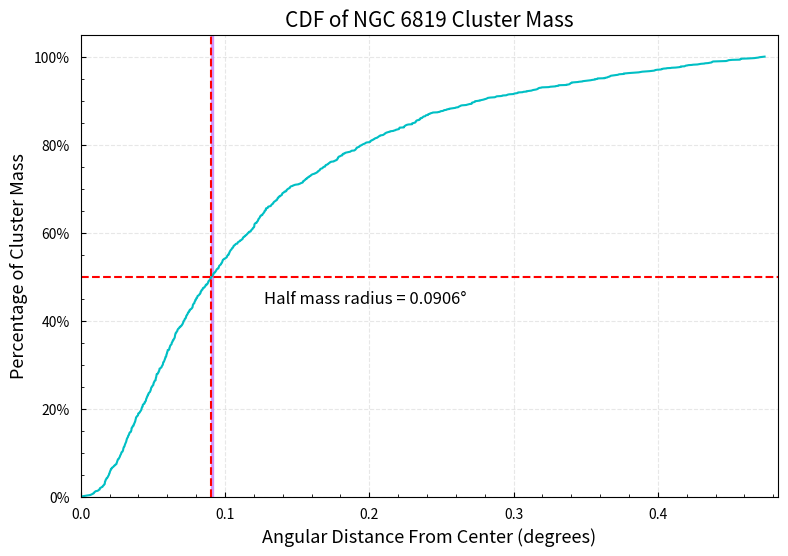

In [124]:
# Create separate total mass columns for binary and single stars
binaryPhot_copy['total_mass'] = binaryPhot_copy['m1Median'] + binaryPhot_copy['m2Median']
singlePhot_copy['total_mass'] = singlePhot_copy['m1Median']

binaryPhot_copy['m2_16th'] = binaryPhot_copy['m1_16'] * binaryPhot_copy['q_16']
binaryPhot_copy['m2_84th'] = binaryPhot_copy['m1_84'] * binaryPhot_copy['q_84']

binaryPhot_copy['total_mass_16th'] = binaryPhot_copy['m1_16'] + binaryPhot_copy['m2_16th']
singlePhot_copy['total_mass_16th'] = singlePhot_copy['m1_16']

binaryPhot_copy['total_mass_84th'] = binaryPhot_copy['m1_84'] + binaryPhot_copy['m2_84th']
singlePhot_copy['total_mass_84th'] = singlePhot_copy['m1_84']

# Concatenate the dataframes
concatenatedGaiaData = pd.concat([binaryPhot_copy, singlePhot_copy])

#Sort the dataframe by distance
concatenatedGaiaData = concatenatedGaiaData.sort_values(by='distance')

# Compute the cumulative sum of the total_mass column
concatenatedGaiaData['cumulative_mass'] = concatenatedGaiaData['total_mass'].cumsum()
concatenatedGaiaData['cumulative_mass_16th'] = concatenatedGaiaData['total_mass_16th'].cumsum()
concatenatedGaiaData['cumulative_mass_84th'] = concatenatedGaiaData['total_mass_84th'].cumsum()

# Compute the total mass
total_mass = concatenatedGaiaData['total_mass'].sum()
total_mass_16th = concatenatedGaiaData['total_mass_16th'].sum()
total_mass_84th = concatenatedGaiaData['total_mass_84th'].sum()

# Compute the cumulative percentage of the total mass
concatenatedGaiaData['cumulative_percentage'] = concatenatedGaiaData['cumulative_mass'] / total_mass * 100
concatenatedGaiaData['cumulative_percentage_16th'] = concatenatedGaiaData['cumulative_mass_16th'] / total_mass_16th * 100
concatenatedGaiaData['cumulative_percentage_84th'] = concatenatedGaiaData['cumulative_mass_84th'] / total_mass_84th * 100

# Find the radius at which half of the total mass is reached
half_mass_radius = concatenatedGaiaData.loc[concatenatedGaiaData['cumulative_percentage'] >= 50, 'distance'].iloc[0]
half_mass_radius_16th = concatenatedGaiaData.loc[concatenatedGaiaData['cumulative_percentage_16th'] >= 50, 'distance'].iloc[0]
half_mass_radius_84th = concatenatedGaiaData.loc[concatenatedGaiaData['cumulative_percentage_84th'] >= 50, 'distance'].iloc[0]

print(half_mass_radius_16th,half_mass_radius,half_mass_radius_84th)

# Plot the cumulative percentage as a function of radius
f,ax = plt.subplots(figsize=(9,6), facecolor='w')
plt.plot(concatenatedGaiaData['distance'], concatenatedGaiaData['cumulative_percentage'], color=pink)
plt.axvline(x=half_mass_radius, color='red', linestyle='--')
# plt.axvline(x=half_mass_radius_16th, color=gold, linestyle='--')
# plt.axvline(x=half_mass_radius_84th, color=gold, linestyle='--')
plt.axvspan(half_mass_radius_16th,half_mass_radius_84th, color=gold, alpha=0.7)
plt.axhline(y=50, color='red', linestyle='--')
plt.annotate(text=f'Half mass radius = {half_mass_radius:.4f}\u00b0', color='black', xy=(.127,44), xytext=(.127,44), size=12)
plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Cluster Mass", fontsize=13)
plt.title("CDF of NGC 6819 Cluster Mass", fontsize=15)
plt.grid(linestyle='--', alpha=0.3)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(100))
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.tick_params(axis='both', pad=8)
ax.set_xlim(0,ten_core_radii)
ax.set_ylim(0,None)
print(total_mass, total_mass/2, half_mass_radius)
plt.show()


In [159]:
test_dist = 10 ** ((distance_mod_mean + 5 - reddening_mean) / 5)
test_dist_1std = 10 ** ((distance_mod_std + 5 - reddening_std) / 5)
print(test_dist)
print(test_dist_1std)
print((test_dist_1std/test_dist)*100)


2418.9307543181408
10.000102853861097
0.41341005053614993


In [160]:
# Calculate half-mass radius
distance = 10 ** ((distance_mod_mean + 5 - reddening_mean) / 5)

r = half_mass_radius * 3600 #convert degrees to arcseconds
R_half_pc = r * distance / 206265  #find half mass radius in pc of cluster
R_half_m = R_half_pc * 3.086 * 10 ** 16 #convert from pc to meters

r_16th = half_mass_radius_16th * 3600 #convert degrees to arcseconds
R_half_pc_16th = r_16th * distance / 206265  #find half mass radius in pc of cluster
R_half_m_16th = R_half_pc_16th * 3.086 * 10 ** 16 #convert from pc to meters

r_84th = half_mass_radius_84th * 3600 #convert degrees to arcseconds
R_half_pc_84th = r_84th * distance / 206265  #find half mass radius in pc of cluster
R_half_m_84th = R_half_pc_84th * 3.086 * 10 ** 16 #convert from pc to meters
print('R_half in meters 16th:', R_half_m_16th,'R_half in meters:', R_half_m, 'R_half in meters 84th:', R_half_m_84th)
print('R_half in pc 16th:', R_half_pc_16th,'R_half in pc:', R_half_pc, 'R_half in pc 84th:', R_half_pc_84th)
R_core = 4.96 * 3600 #not sure what the core radius is that was used
a = R_core * np.sqrt(2)

# find the sums of binaries and single stars, and add them together for total mass
binaryMass = sum(binaryPhot_copy['total_mass'])
singleMass = sum(singlePhot_copy['total_mass'])
cluster_mass = binaryMass + singleMass

binaryMass_16th = sum(binaryPhot_copy['total_mass_16th'])
singleMass_16th = sum(singlePhot_copy['total_mass_16th'])
cluster_mass_16th = binaryMass_16th + singleMass_16th

binaryMass_84th = sum(binaryPhot_copy['total_mass_84th'])
singleMass_84th = sum(singlePhot_copy['total_mass_84th'])
cluster_mass_84th = binaryMass_84th + singleMass_84th

print(cluster_mass_16th,cluster_mass,cluster_mass_84th)
# convert total mass from solar masses to kilograms
M = cluster_mass * 1.9891 * 10 ** 30 
M_16th = cluster_mass_16th * 1.9891 * 10 ** 30 
M_84th = cluster_mass_84th * 1.9891 * 10 ** 30 
print(M_16th,M,M_84th)
# gravitational constant
G = 6.67 * 10 ** -11 
# number of members
N = len(photMems_copy)
const = 0.1

# Binney & Tremaine half mass relaxation time equation NOTE can replace M with nm or N with M/m
t_rh = (((0.17 * N) / np.log(const * N)) * (math.sqrt(((R_half_m) ** 3) / (G * M)))) / 31536000
#calc avg mass, likely .5 w uncertainty of .1 
# Spitzer & Hart half mass relaxation time equation
m = np.mean(photMems_copy['m1Median']) * 1.9891 * 10 ** 30
print(m)
t_rh_spitzer = (0.06 * (M ** 0.5) * (R_half_m ** 1.5)) / (m * (G ** 0.5) * np.log10(0.4 * N)) / 31536000

#Heggie & Hut - Plummer Model half mass relaxation time equation, not sure what lambda is
t_rh_heggie = ( (0.206 * N * (a**1.5)) / (np.sqrt(G*M) * np.log(10)) ) / 31536000 #from table
t_rh_heggie2 = ( (0.138 * (N**0.5) * (R_half_m**1.5)) / (np.sqrt(G*m) * np.log(10)) ) / 31536000 #from pg 147

# Calculate the mass segregation time for the most massive star
# Calculate max m and avg m
#NOTICE the t_seg being calculated here:
avg_m = (cluster_mass / N)* 1.9891 * 10 ** 30
m_max = max(photMems_copy['m1Median']) * 1.9891 * 10 ** 30
t_seg = (avg_m / m_max) * t_rh
cluster_age = 10**np.mean(age_all)

# print results with labels and units
print(f"Half-mass radius: {R_half_pc:.2f} pc")
print(f'Total cluster mass: {cluster_mass:.2e} M☉\n')
print(f"Half-mass relaxation time (Binney & Tremaine): {t_rh:.2e} years")
print(f"Half-mass relaxation time (Spitzer & Hart): {t_rh_spitzer:.2e} years")
print(f"Half-mass relaxation time (Heggie & Hut - Plummer): {t_rh_heggie2:.2e} years")
print(f"Mass segregation time for the most massive star (Binney & Tremaine): {t_seg:.2e} years\n")
print(f'Dynamical Relaxations (Binney & Tremaine): {cluster_age/t_rh}')
print(f'Dynamical Relaxations (Spitzer & Hart): {cluster_age/t_rh_spitzer}')
print(f'Dynamical Relaxations (Heggie & Hut - Plummer): {cluster_age/t_rh_heggie2}')

R_half in meters 16th: 1.1986655279436398e+17 R_half in meters: 1.1807530972562762e+17 R_half in meters 84th: 1.1767726980131179e+17
R_half in pc 16th: 3.884204562357874 R_half in pc: 3.8261603929237724 R_half in pc 84th: 3.8132621452142517
1541.1578406478834 1581.748011213698 1613.1409572713744
3.065517060832705e+33 3.146254969105167e+33 3.208698678108491e+33
2.1517140124157647e+30
Half-mass radius: 3.83 pc
Total cluster mass: 1.58e+03 M☉

Half-mass relaxation time (Binney & Tremaine): 1.26e+08 years
Half-mass relaxation time (Spitzer & Hart): 9.10e+07 years
Half-mass relaxation time (Heggie & Hut - Plummer): 2.30e+08 years
Mass segregation time for the most massive star (Binney & Tremaine): 1.07e+08 years

Dynamical Relaxations (Binney & Tremaine): 19.293618334010308
Dynamical Relaxations (Spitzer & Hart): 26.620662469127243
Dynamical Relaxations (Heggie & Hut - Plummer): 10.540872996929396


In [126]:
# import sympy as sp

# t_rh=(((0.17*N)/sp.log(const*N))*(sp.sqrt(((R_half_m)**3)/(G*M))))/31536000

# delta_t_rh1 = 1.0353301324663e+30*sp.sqrt(4.06444346441545e-67*N*(sp.sqrt(R_half_m**3/M)/sp.log(0.1*N) - sp.sqrt(R_half_m**3/M)/sp.log(0.1*N)**2)**2 + 2.61432677386437e-73*N**2*R_half_m/(M*sp.log(0.1*N)**2) + N**2*R_half_m**3*(3.18764939430902e-34*M - 1)**2/(M**3*sp.log(0.1*N)**2))
# print(delta_t_rh1)

# half_mass_radius_m= (half_mass_radius * 3600 * distance * 3.086 * 10 ** 16)/ 206265
# half_mass_radius_16th_m = (half_mass_radius_16th * 3600 * distance * 3.086 * 10 ** 16)/ 206265
# half_mass_radius_84th_m = (half_mass_radius_84th * 3600 * distance * 3.086 * 10 ** 16)/ 206265


# delta_N = sp.sqrt(N)
# delta_R = half_mass_radius_m - ((half_mass_radius_16th_m+half_mass_radius_84th_m)/2)
# delta_M =M- ((M_16th + M_84th)/2)
# percent= (delta_M/M)*100
# print(M,delta_M,percent)

# N, R_half_m, M = sp.symbols('N R_half_m M')


# t_rh1=(((0.17*N)/sp.log(const*N))*(sp.sqrt(((R_half_m)**3)/(G*M))))/31536000



# d_N = t_rh1.diff(N)
# d_R = t_rh1.diff(R_half_m)
# d_M = t_rh1.diff(M)

# delta_t_rh = sp.sqrt((d_N * delta_N) ** 2  + (d_R * delta_R) ** 2 + (d_M* delta_M) ** 2)

# print(delta_t_rh)

In [127]:
M1 = cluster_mass * 1.9891 * 10 ** 30 
N1 = len(photMems_copy)
R_half_m1 = R_half_pc * 3.086 * 10 ** 16 #convert from pc to meters

#old eq, before adjusting delta_R to be in meters
#delta_t_rh2 = 1.0353301324663e+30*sp.sqrt(4.06444346441545e-67*N1*(sp.sqrt(R_half_m1**3/M1)/sp.log(0.1*N1) - sp.sqrt(R_half_m1**3/M1)/sp.log(0.1*N1)**2)**2 + 2.61432677386437e-73*N1**2*R_half_m1/(M1*sp.log(0.1*N1)**2) + N1**2*R_half_m1**3*(3.18764939430902e-34*M1 - 1)**2/(M1**3*sp.log(0.1*N1)**2))
delta_t_rh2 = 3.01878936599603e+27*sp.sqrt(6.0954160855056e-59*(sp.sqrt(R_half_m1**3/M1)/sp.log(0.1*N1) - sp.sqrt(R_half_m1**3/M1)/sp.log(0.1*N1)**2)**2 + 5.21968855725125e-32*N1**2*R_half_m1/(M1*sp.log(0.1*N1)**2) + N1**2*R_half_m1**3/(M1**3*sp.log(0.1*N1)**2))

#print(delta_t_rh2, t_rh)
print(f"Half-mass relaxation time (Binney & Tremaine): {t_rh:.2e} years")
print(f"Half-mass relaxation time propagated uncertainty (Binney & Tremaine): {delta_t_rh2:.2e} years")

Half-mass relaxation time (Binney & Tremaine): 1.26e+08 years
Half-mass relaxation time propagated uncertainty (Binney & Tremaine): 3.01e+6 years


In [128]:
#Calculate t_seg for each star with Binney & Tremaine model, and store it in phot dataframe for later
avg_star_mass = (cluster_mass / N) 
#m_star = photMems_copy['m1Median'] * 1.9891e30 
# photMems_copy['t_seg'] = (avg_m / m_star) * t_rh
#avg star mass changes based on binary vs not binary? 
binaryPhot_copy['t_seg'] = (avg_star_mass / (binaryPhot_copy['total_mass'] ) ) *t_rh
singlePhot_copy['t_seg'] = (avg_star_mass / (singlePhot_copy['total_mass'] ) ) *t_rh

In [129]:
#np.mean(binaryPhot_copy['t_seg']/1e9)

# Diagnostic Plots

twoside p-value: 0.0012210203338221977 
twoside p-value < 0.3 degrees: 0.00020494178756350274


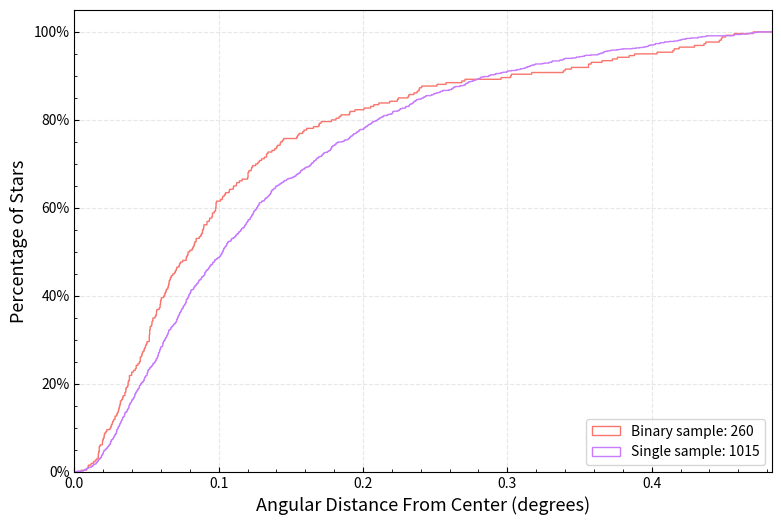

In [130]:
#full sample CDF
f,ax = plt.subplots(figsize=(9,6), facecolor='w')

single = singlePhot_copy['distance']
binary = binaryPhot_copy['distance']

singleSample = single.shape[0]
binarySample = binary.shape[0]

ax.hist(binary, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 3200,color=blue, label=f'Binary sample: {binarySample}')
ax.hist(single, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 3200, color=gold, label=f'Single sample: {singleSample}')

mask = 0.3
singlemask = singlePhot_copy['distance'][singlePhot_copy['distance'] < mask]
binarymask = binaryPhot_copy['distance'][binaryPhot_copy['distance'] < mask]

ks_result, twoside_pvalue = ks_2samp(single,binary)
ks_result, twoside_pvaluemask = ks_2samp(singlemask,binarymask)
ks_result, less_pvalue = ks_2samp(single,binary,alternative='less')
print("twoside p-value:", twoside_pvalue, f'\ntwoside p-value < {mask} degrees:', twoside_pvaluemask)

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
#plt.title("CDF of NGC 6819 Gaia Members", fontsize=15)
plt.legend(loc='lower right')
plt.grid(linestyle='--', alpha=0.3)

from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,ten_core_radii)
plt.savefig('binarysingleCDF.pdf',dpi=300, bbox_inches="tight")

In [131]:
#NEW CODE
Nbins= [0,  0.08055556, 0.16111111, 0.24166667, 0.48333333]
fracfilter = 0
binaryfrac_filtered = binaryPhot_copy.loc[binaryPhot_copy['m1Median'] > fracfilter]
photMems_filtered = photMems_copy.loc[photMems_copy['m1Median'] > fracfilter]
counts, bins3, bars =plt.hist(binaryfrac_filtered['distance'], bins=Nbins,linewidth=2,color='purple',rwidth=0.97)
plt.xlabel('Distance from Cluster Center',fontsize=15)
plt.ylabel('N (binaries)',fontsize=15)

counts2, bins4, bars2 = plt.hist(photMems_filtered['distance'], bins= Nbins, range=[0,1],linewidth=2,color='purple',rwidth=0.97)
plt.xlabel('Distance from Cluster Center',fontsize=15)
plt.ylabel('N',fontsize=15)

errors_y = np.sqrt(counts)/counts2
primarybins2 = bins3[:-1] + np.diff((bins3)/2)

# print(counts2)
# print(bins3,bins4)
# print(primarybins2)

plt.xlim(0,ten_core_radii)
plt.close()

In [161]:
print(counts, counts2)

[131.  71.  26.  32.] [544. 361. 186. 184.]


0.0037943495202352965


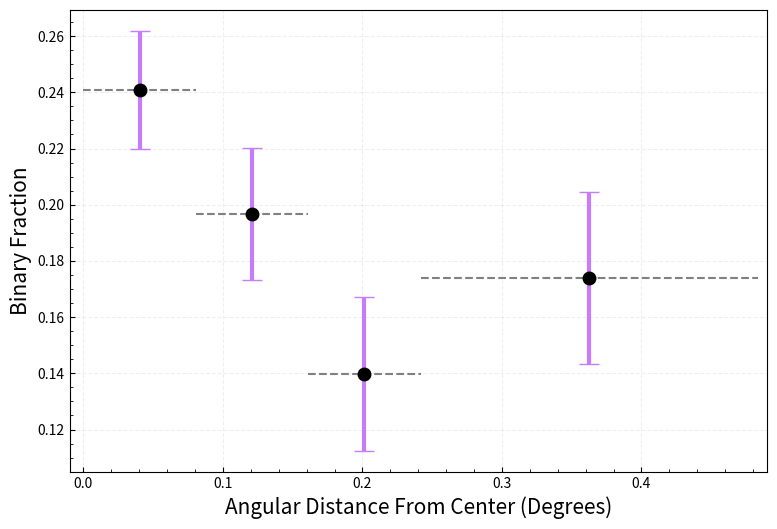

In [166]:
#NEW CODE
f,ax = plt.subplots(figsize=(9,6), facecolor='w')

ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
plt.grid(linestyle='--', alpha=0.2)
plt.xlim(-0.01,.49)
plt.xlabel('Angular Distance From Center (Degrees)', fontsize=15)
plt.ylabel('Binary Fraction', fontsize=15)
eb1 = plt.errorbar(primarybins2, counts/counts2, xerr= np.diff((bins3)/2), fmt='o', capsize=0, elinewidth=1.5,color='gray', ecolor='gray',markersize=3,linewidth=2)
eb1[-1][0].set_linestyle('--') #eb1[-1][0] is the LineCollection objects of the errorbar lines
plt.errorbar(primarybins2, counts/counts2, xerr= None, yerr=errors_y, fmt='o', capsize=7, elinewidth=3,color='black', ecolor=gold, markersize=9,linewidth=2)

from statsmodels.stats.proportion import proportions_ztest
count1 = np.array([131,26]) #binaries?
nobs = np.array([544,186]) #mems?
stats, pval = proportions_ztest(count1, nobs)
print(pval)

plt.savefig('binaryfrac.pdf',dpi=300, bbox_inches="tight")

In [133]:
# # Define the minimum and maximum values for 'm1Median'
# m1Median_min = 0.6530235
# m1Median_max = 1.4463855

# # Divide the range into three equal intervals
# interval_size = (m1Median_max - m1Median_min) / 3

# # Define the lower and upper bounds for each interval
# lower_bound1 = m1Median_min
# upper_bound1 = m1Median_min + interval_size

# lower_bound2 = upper_bound1
# upper_bound2 = upper_bound1 + interval_size

# lower_bound3 = upper_bound2
# upper_bound3 = m1Median_max

# # Create three different data sets based on the intervals
# data_set1 = binaryPhot_copy[(binaryPhot_copy['m1Median'] >= lower_bound1) & (binaryPhot_copy['m1Median'] < upper_bound1)]
# data_set2 = binaryPhot_copy[(binaryPhot_copy['m1Median'] >= lower_bound2) & (binaryPhot_copy['m1Median'] < upper_bound2)]
# data_set3 = binaryPhot_copy[(binaryPhot_copy['m1Median'] >= lower_bound3) & (binaryPhot_copy['m1Median'] <= upper_bound3)]
# photmems_dataset1 = photMems_copy[(photMems_copy['m1Median'] >= lower_bound1) & (photMems_copy['m1Median'] < upper_bound1)]
# photmems_dataset2 = photMems_copy[(photMems_copy['m1Median'] >= lower_bound2) & (photMems_copy['m1Median'] < upper_bound2)]
# photmems_dataset3 = photMems_copy[(photMems_copy['m1Median'] >= lower_bound3) & (photMems_copy['m1Median'] < upper_bound3)]

# # Plot the three data sets
# Nbins = [0, 0.08055556, 0.16111111, 0.24166667, 0.48333333]

# counts1, bins1, bars1 = plt.hist(data_set1['distance'], bins=Nbins, linewidth=2, color='purple', rwidth=0.97)
# counts2, bins2, bars2 = plt.hist(data_set2['distance'], bins=Nbins, linewidth=2, color='blue', rwidth=0.97)
# counts3, bins3, bars3 = plt.hist(data_set3['distance'], bins=Nbins, linewidth=2, color='green', rwidth=0.97)
# counts4, bins4, bars4 = plt.hist(photmems_dataset1['distance'], bins= Nbins, range=[0,1],linewidth=2,color='purple',rwidth=0.97)
# counts5, bins4, bars4 = plt.hist(photmems_dataset2['distance'], bins= Nbins, range=[0,1],linewidth=2,color='purple',rwidth=0.97)
# counts6, bins4, bars4 = plt.hist(photmems_dataset3['distance'], bins= Nbins, range=[0,1],linewidth=2,color='purple',rwidth=0.97)

# plt.xlabel('Distance from Cluster Center', fontsize=15)
# plt.ylabel('N (binaries)', fontsize=15)

# errors_y1 = np.sqrt(counts1)/counts4
# errors_y2 = np.sqrt(counts2)/counts5
# errors_y3 = np.sqrt(counts3)/counts6

# primarybins1 = bins1[:-1] + np.diff((bins1)/2)
# primarybins2 = bins2[:-1] + np.diff((bins2)/2)
# primarybins3 = bins3[:-1] + np.diff((bins3)/2)
# plt.close()
# f,ax = plt.subplots(figsize=(9,6), facecolor='w')

# ax.yaxis.get_ticklocs(minor=True)
# ax.minorticks_on()
# ax.tick_params(which='both', direction="in")
# plt.grid(linestyle='--', alpha=0.4)
# plt.xlim(-0.01,.5)
# plt.xlabel('Angular Distance From Center (Degrees)', fontsize=15)
# plt.ylabel('Binary Fraction', fontsize=15)
# plt.errorbar(primarybins1, counts1/counts4, xerr= np.diff((bins1)/2), yerr=errors_y1, fmt='o', capsize=7, elinewidth=3,color='black', ecolor='black',markersize=9,linewidth=2)
# plt.errorbar(primarybins2, counts2/counts4, xerr= np.diff((bins2)/2), yerr=errors_y2, fmt='o', capsize=7, elinewidth=3,color='red', ecolor='red',markersize=9,linewidth=2)
# plt.errorbar(primarybins3, counts3/counts4, xerr= np.diff((bins3)/2), yerr=errors_y3, fmt='o', capsize=7, elinewidth=3,color='blue', ecolor='blue',markersize=9,linewidth=2)
# #plt.savefig('M35plot1.pdf',dpi=300, bbox_inches="tight")

In [134]:
np.min(binaryPhot_copy['m1Median']) 

0.6530235

In [135]:
np.diff(bins3)

array([0.08055556, 0.08055555, 0.08055556, 0.24166666])

(0.0, 1.0)

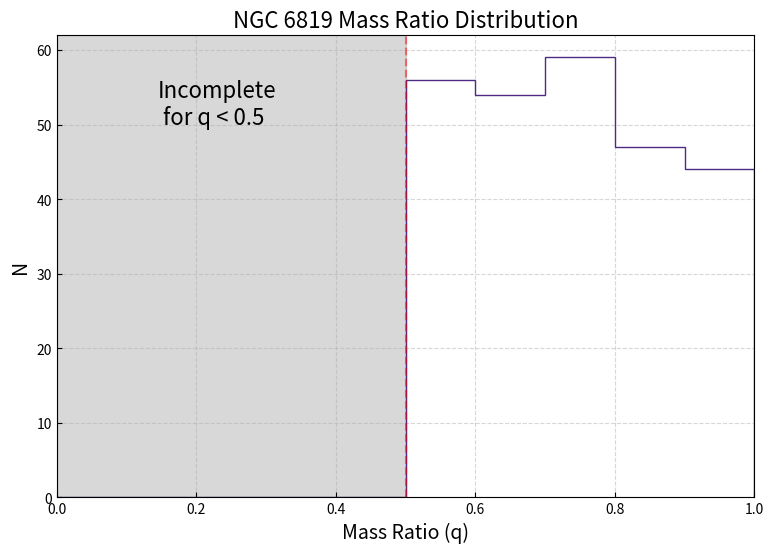

In [136]:
f, ax = plt.subplots(figsize=(9,6), facecolor='w')
photBinary = phot.loc[phot['binary']]
_ = ax.hist(binaryPhot_copy['qMedian'], histtype='step', color="#4e2a84" ,bins=10, range=[0,1])
ax.set_xlabel("Mass Ratio (q)", fontsize=14)
ax.set_ylabel("N", fontsize=14)
ax.annotate(text='Incomplete\n for q < 0.5', xy=(.145,50), xytext=(.145,50), fontsize=16)
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
ax.axvspan(0,0.5, color='gray', alpha=0.3)
ax.set_title("NGC 6819 Mass Ratio Distribution", fontsize=16)
plt.grid(linestyle='--', alpha=0.5)
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,1)
#plt.savefig("massratio.png", dpi=300)

# Other Plots 

In [137]:
# #massratio CDF
# # Select rows where qMean is greater than or equal to 0.5
# qcutSingle = singlePhot_copy[singlePhot_copy['qMedian'] >= 0.00000000001]
# qcutBinary = binaryPhot_copy[binaryPhot_copy['qMedian'] >= 0.5]

# f,ax = plt.subplots(figsize=(9,6), facecolor='w')

# single = qcutSingle['distance']
# binary = qcutBinary['distance']

# singleSample = single.shape[0]
# binarySample = binary.shape[0]

# binaryhist = ax.hist(binary, cumulative = True, density = True, histtype = "step", bins = 5000,color='#dc267f', label= f'Binary sample: {binarySample}')
# singlehist = ax.hist(single, cumulative = True, density = True, histtype = "step", bins = 5000, color='#648fff', label=f'Single sample: {singleSample}')

# mask = 0.4
# singlemask = qcutSingle['distance'][qcutSingle['distance'] < mask]
# binarymask = qcutBinary['distance'][qcutBinary['distance'] < mask]

# ks_result, twoside_pvalue = ks_2samp(single,binary)
# ks_result, twoside_pvaluemask = ks_2samp(singlemask,binarymask)
# ks_result, less_pvalue = ks_2samp(single,binary,alternative='less')
# print("twoside p-value:", twoside_pvalue, f'\ntwoside p-value < {mask} degrees:', twoside_pvaluemask)

# plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
# plt.ylabel("Percentage of Stars", fontsize=13)
# plt.title("CDF of NGC 6819 Gaia Members with q >= 0.5", fontsize=15)
# plt.grid(linestyle='--', alpha=0.3)
# plt.legend(loc='upper left')
# # plt.text(.008, .88, f'K-S "two-sided" P-value: {twoside_pvalue:.5f}\nK-S "less" P-value: {less_pvalue:.5f}\nBinary sample: {binarySample}\nSingle sample: {singleSample}',fontsize = 10, 
# #          bbox = dict(facecolor='w', boxstyle='round', edgecolor='lightgray'))
# # custom_lines = [Line2D([0], [0], color='g',alpha=1, lw=2, ls='-'),
# #                                 Line2D([0], [0], color='b',alpha=1, lw=2, ls='-'),]

# # twoside= ax.plot(1, 1, alpha= 0, label=f'K-S "two-sided" P-value: {twoside_pvalue:.5f}', color=None, linestyle=None)
# # less= ax.plot(1, 1, alpha= 0, label=f'K-S "two-sided" P-value: {less_pvalue:.5f}', color=None, linestyle=None)
# #ax.legend(loc=2, fontsize=8)
# #leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True, loc=2, fontsize=9)
# #plt.legend(custom_lines, ['Binary stars', 'Single stars'],loc=2, fontsize=10)

# # plt.annotate(text="Binary stars", color='g', xy=(.09,.81), xytext=(.09,.81), size=12)
# # plt.annotate(text="Single stars", color='b', xy=(.155,.69), xytext=(.155,.69), size=12)
# from matplotlib.ticker import PercentFormatter
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# ax.yaxis.get_ticklocs(minor=True)
# ax.minorticks_on()
# ax.tick_params(which='both', direction="in")
# ax.tick_params(axis='both', pad=8)
# ax.set_xlim(0,.614)
# plt.show()

8 15


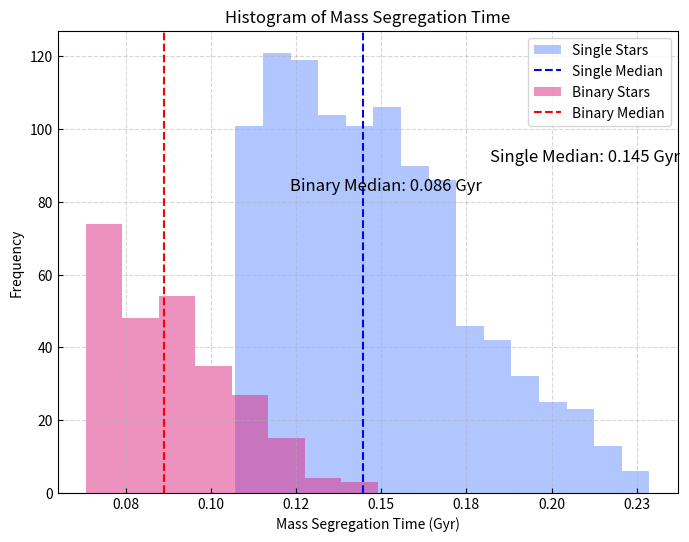

In [138]:
#t_seg hist
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(8, 6), facecolor='w')
bins = 20

# Calculate the interquartile range (IQR)
iqr_single = np.percentile(singlePhot_copy['t_seg'], 75) - np.percentile(singlePhot_copy['t_seg'], 25)
iqr_binary = np.percentile(binaryPhot_copy['t_seg'], 75) - np.percentile(binaryPhot_copy['t_seg'], 25)

# Calculate the bin width using the Freedman-Diaconis rule
bin_width_single = 2 * iqr_single * (len(singlePhot_copy['t_seg']) ** (-1/3))
bin_width_binary = 2 * iqr_binary * (len(binaryPhot_copy['t_seg']) ** (-1/3))

# Calculate the number of bins using the bin width
bins_single = int((np.max(singlePhot_copy['t_seg']) - np.min(singlePhot_copy['t_seg'])) / bin_width_single)
bins_binary = int((np.max(binaryPhot_copy['t_seg']) - np.min(binaryPhot_copy['t_seg'])) / bin_width_binary)
print(bins_binary,bins_single)

plt.grid(linestyle='--', alpha=0.5)
ax.tick_params(which='both', direction="in")

single_median = np.median(singlePhot_copy['t_seg'])
binary_median = np.median(binaryPhot_copy['t_seg'])

single_counts, single_bins, _ = ax.hist(singlePhot_copy['t_seg'], bins=bins_single, alpha=0.5, color='#648fff', label='Single Stars')
ax.axvline(np.median(singlePhot_copy['t_seg']), ls='--', c='b', label='Single Median')
binary_counts, binary_bins, _ = ax.hist(binaryPhot_copy['t_seg'], bins=bins_binary, alpha=0.5, color='#dc267f', label='Binary Stars')
ax.axvline(np.median(binaryPhot_copy['t_seg']), ls='--', c='r', label='Binary Median')

ax.annotate(text=f'Single Median: {single_median/1e9:.3f} Gyr', 
             xy=(single_median+.65e8, 120), xytext=(single_median+.65e8, 120-30),
             ha='center', va='bottom', size=12)
ax.annotate(text=f'Binary Median: {binary_median/1e9:.3f} Gyr', 
             xy=(binary_median+.65e8,112), xytext=(binary_median+.65e8, 112-30),
             ha='center', va='bottom', size=12)

ax.set_xlabel('Mass Segregation Time (Gyr)')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Mass Segregation Time')
ax.legend()

# Define the conversion function
def year_to_gigayear(x, pos):
    return f'{x * 1e-9:.2f}'

# Create a FuncFormatter object using the conversion function
formatter = ticker.FuncFormatter(year_to_gigayear)

# Apply the formatter to the x-axis
ax.xaxis.set_major_formatter(formatter)


In [139]:
# import matplotlib.pyplot as plt
# from matplotlib.patches import Circle

# fig, ax = plt.subplots(figsize=(8, 6), facecolor='w')

# ax.tick_params(which='both', direction="in")

# # Filter binary stars by t_seg
# binary_filtered = binaryPhot_copy[(binaryPhot_copy['t_seg'] >= 0.187e9) & (binaryPhot_copy['distance'] <= 0.6)]

# # Scatter plot for binary stars
# sc_binary = ax.scatter(binary_filtered['ra'], binary_filtered['dec'], edgecolors='black', linewidth=.9, c=binary_filtered['t_seg']/1e9, cmap=plt.cm.get_cmap("viridis").reversed(), label='Binary Stars', s=30)

# # Filter single stars by t_seg
# single_filtered = singlePhot_copy[(singlePhot_copy['t_seg'] >= 0.187e9) & (singlePhot_copy['distance'] <= 0.6)]

# # Scatter plot for single stars
# sc_single = ax.scatter(single_filtered['ra'], single_filtered['dec'], c=single_filtered['t_seg']/1e9, cmap=plt.cm.get_cmap("viridis").reversed(), edgecolors='white',label='Single Stars', s=20)

# # Add circular contours
# center = (295.3250, 40.19)  # Specify the central point coordinates
# radii = [0.3, np.max(binaryPhot_copy['distance'])]  # Specify the radii for the contours

# counts_binary = []  # Number of binary stars within each contour
# counts_single = []  # Number of single stars within each contour

# for radius in radii:
#     circle = Circle(center, radius, facecolor='none', edgecolor='gray', linestyle='--', linewidth=1)
#     ax.add_patch(circle)

#     # Check if stars are within the circular contour
#     binary_mask = (binary_filtered['ra'] - center[0])**2 + (binary_filtered['dec'] - center[1])**2 <= radius**2
#     single_mask = (single_filtered['ra'] - center[0])**2 + (single_filtered['dec'] - center[1])**2 <= radius**2

#     count_binary = binary_mask.sum()  # Count the number of binary stars within the contour
#     count_single = single_mask.sum()  # Count the number of single stars within the contour

#     counts_binary.append(count_binary)
#     counts_single.append(count_single)

#     # Display the counts
#     #ax.text(center[0] + radius - 0.1, center[1] + radius - 0.8, f'Binaries: {count_binary}\nSingles: {count_single}', fontsize=10)

# # Colorbar for binary stars
# cbar = plt.colorbar(sc_binary)
# cbar.set_label('t_seg (Gyr)')
# cbar.ax.tick_params(labelsize=12)

# # Legend for single stars
# ax.legend(fontsize=9)
# plt.grid(linestyle='--', alpha=0.3)
# ax.set_xlabel('Right Ascension (Degrees)', fontsize=14)
# ax.set_ylabel('Declination (Degrees)', fontsize=14)
# # ax.set_title('RA vs DEC', fontsize=16)
# # ax.set_xlim(295, 295.7)
# # ax.set_ylim(40, 40.4)
# plt.show()

# # Print the counts for each circular contour
# print("Counts - Binary:", counts_binary)
# print("Counts - Single:", counts_single)


In [140]:
number_bins = 4

# Sort the data in ascending order
sorted_data = np.sort(binaryPhot_copy['t_seg'])

# Calculate the total number of data points
total_points = len(sorted_data)

# Calculate the sample size for each bin
sample_size = total_points // number_bins

# Initialize an empty list to store the bin endpoints
binary_endpoints = []

# Iterate over the number of bins
for i in range(number_bins):
    # Calculate the indices for the start and end of the current bin
    start_index = i * sample_size
    end_index = start_index + sample_size - 1
    
    # Append the bin endpoints to the list
    binary_endpoints.append(sorted_data[end_index])

#print(bin_endpoints)

Min: 0.063 Gyr 
Max: 0.149 Gyr
0.09803245224112749
0.5651455041513576
0.007459965710941828
0.002112466385728937


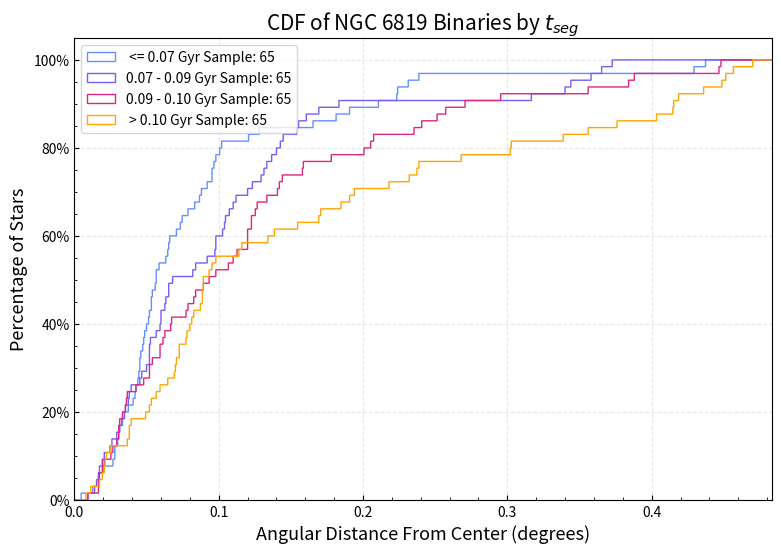

In [141]:
#t_seg bins for BINARY stars
f,ax = plt.subplots(figsize=(9,6), facecolor='w')

min_tseg = np.min(binaryPhot_copy['t_seg'])
max_tseg = np.max(binaryPhot_copy['t_seg'])
print(f'Min: {min_tseg/1e9:.3f} Gyr', f'\nMax: {max_tseg/1e9:.3f} Gyr')

binaryfilter1 = binaryPhot_copy.loc[(binaryPhot_copy['t_seg']  >= min_tseg) & (binaryPhot_copy['t_seg']  <= binary_endpoints[0])]
binaryfilter2 = binaryPhot_copy.loc[(binaryPhot_copy['t_seg']  > binary_endpoints[0]) & (binaryPhot_copy['t_seg']  <=  binary_endpoints[1])]
binaryfilter3 = binaryPhot_copy.loc[(binaryPhot_copy['t_seg']  > binary_endpoints[1] ) & (binaryPhot_copy['t_seg']  <=  binary_endpoints[2])]
binaryfilter4 = binaryPhot_copy.loc[(binaryPhot_copy['t_seg']  > binary_endpoints[2] ) & (binaryPhot_copy['t_seg']  <= max_tseg)]

#print(binaryfilter1)
#binary = binaryGaiaData.loc[(binaryGaiaData['m1Mean']  > 1) & (binaryGaiaData['m1Mean']  <  1.3)]

binarybin1 = binaryfilter1['distance']
binarybin2 = binaryfilter2['distance']
binarybin3 = binaryfilter3['distance']
binarybin4 = binaryfilter4['distance']
allbinaries = binaryPhot_copy['distance']

binarybin1Sample = binarybin1.shape[0]
binarybin2Sample = binarybin2.shape[0]
binarybin3Sample = binarybin3.shape[0]
binarybin4Sample = binarybin4.shape[0]
allSample = binaryPhot_copy.shape[0]
# print(binary)

ax.hist(binarybin1, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#648fff', label=f' <= {binary_endpoints[0]/1e9:.2f} Gyr Sample: {binarybin1Sample}')
ax.hist(binarybin2, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#785ef0', label=f'{binary_endpoints[0]/1e9:.2f} - {binary_endpoints[1]/1e9:.2f} Gyr Sample: {binarybin2Sample}')
ax.hist(binarybin3, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#dc267f', label=f'{binary_endpoints[1]/1e9:.2f} - {binary_endpoints[2]/1e9:.2f} Gyr Sample: {binarybin3Sample}')
ax.hist(binarybin4, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='orange', label=f' > {binary_endpoints[2]/1e9:.2f} Gyr Sample: {binarybin4Sample}')
#ax.hist(allbinaries, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#FFB000', label=f'All Samples: {allSample}')


ks_result, twoside_pvalue1 = ks_2samp(binarybin1,binarybin2)
ks_result, less_pvalue1 = ks_2samp(binarybin1,binarybin2,alternative='less')
print(twoside_pvalue1)

ks_result, twoside_pvalue2 = ks_2samp(binarybin2,binarybin3)
ks_result, less_pvalue2= ks_2samp(binarybin2,binarybin3,alternative='less')
print(twoside_pvalue2)

ks_result, twoside_pvalue3= ks_2samp(binarybin1,binarybin3)
ks_result, less_pvalue3 = ks_2samp(binarybin1,binarybin3,alternative='less')
print(twoside_pvalue3)

ks_result, twoside_pvalue4= ks_2samp(binarybin1,binarybin4)
ks_result, less_pvalue4 = ks_2samp(binarybin1,binarybin4,alternative='less')
print(twoside_pvalue4)

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Binaries by $t_{seg}$", fontsize=15)
plt.legend(loc='upper left')
plt.grid(linestyle='--', alpha=0.3)

from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,ten_core_radii)
plt.show()

In [142]:
number_bins = 4

# Sort the data in ascending order
sorted_data = np.sort(singlePhot_copy['t_seg'])

# Calculate the total number of data points
total_points = len(sorted_data)

# Calculate the sample size for each bin
sample_size = total_points // number_bins

# Initialize an empty list to store the bin endpoints
single_endpoints = []

# Iterate over the number of bins
for i in range(number_bins):
    # Calculate the indices for the start and end of the current bin
    start_index = i * sample_size
    end_index = start_index + sample_size - 1
    
    # Append the bin endpoints to the list
    single_endpoints.append(sorted_data[end_index])

#print(bin_endpoints)

Min: 0.107 Gyr 
Max: 0.229 Gyr
0.026918989718861096
0.13827325259466952
0.0018406919234291066
2.4758297576644057e-05


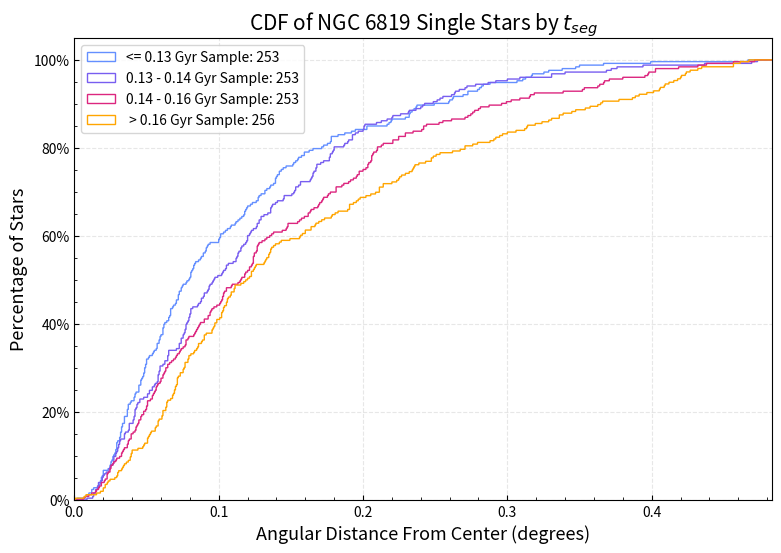

In [143]:
#t_seg bins for SINGLE stars
f,ax = plt.subplots(figsize=(9,6), facecolor='w')

min_tseg = np.min(singlePhot_copy['t_seg'])
max_tseg = np.max(singlePhot_copy['t_seg'])
print(f'Min: {min_tseg/1e9:.3f} Gyr', f'\nMax: {max_tseg/1e9:.3f} Gyr')

singlefilter1 = singlePhot_copy.loc[(singlePhot_copy['t_seg']  >= min_tseg) & (singlePhot_copy['t_seg']  <= single_endpoints[0])]
singlefilter2 = singlePhot_copy.loc[(singlePhot_copy['t_seg']  > single_endpoints[0]) & (singlePhot_copy['t_seg']  <=  single_endpoints[1])]
singlefilter3 = singlePhot_copy.loc[(singlePhot_copy['t_seg']  > single_endpoints[1] ) & (singlePhot_copy['t_seg']  <=  single_endpoints[2])]
singlefilter4 = singlePhot_copy.loc[(singlePhot_copy['t_seg']  > single_endpoints[2] ) & (singlePhot_copy['t_seg']  <= max_tseg)]

#print(binaryfilter1)
#binary = binaryGaiaData.loc[(binaryGaiaData['m1Mean']  > 1) & (binaryGaiaData['m1Mean']  <  1.3)]

singlebin1 = singlefilter1['distance']
singlebin2 = singlefilter2['distance']
singlebin3 = singlefilter3['distance']
singlebin4 = singlefilter4['distance']
#allsingle = singlePhot_copy['distance']

singlebin1Sample = singlebin1.shape[0]
singlebin2Sample = singlebin2.shape[0]
singlebin3Sample = singlebin3.shape[0]
singlebin4Sample = singlebin4.shape[0]
#allSample = singlePhot_copy.shape[0]
# print(binary)

ax.hist(singlebin1, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#648fff', label=f'<= {single_endpoints[0]/1e9:.2f} Gyr Sample: {singlebin1Sample}')
ax.hist(singlebin2, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#785ef0', label=f'{single_endpoints[0]/1e9:.2f} - {single_endpoints[1]/1e9:.2f} Gyr Sample: {singlebin2Sample}')
ax.hist(singlebin3, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#dc267f', label=f'{single_endpoints[1]/1e9:.2f} - {single_endpoints[2]/1e9:.2f} Gyr Sample: {singlebin3Sample}')
ax.hist(singlebin4, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='orange', label=f' > {single_endpoints[2]/1e9:.2f} Gyr Sample: {singlebin4Sample}')
#ax.hist(allsingle, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#FFB000', label=f'All Samples: {allSample}')


ks_result, twoside_pvalue1 = ks_2samp(singlebin1,singlebin2)
ks_result, less_pvalue1 = ks_2samp(singlebin1,singlebin2,alternative='less')
print(twoside_pvalue1)

ks_result, twoside_pvalue2 = ks_2samp(singlebin2,singlebin3)
ks_result, less_pvalue2= ks_2samp(singlebin2,singlebin3,alternative='less')
print(twoside_pvalue2)

ks_result, twoside_pvalue3= ks_2samp(singlebin1,singlebin3)
ks_result, less_pvalue3 = ks_2samp(singlebin1,singlebin3,alternative='less')
print(twoside_pvalue3)

ks_result, twoside_pvalue4= ks_2samp(singlebin1,singlebin4)
ks_result, less_pvalue4 = ks_2samp(singlebin1,singlebin4,alternative='less')
print(twoside_pvalue4)

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Single Stars by $t_{seg}$", fontsize=15)
plt.legend(loc='upper left')
plt.grid(linestyle='--', alpha=0.3)

from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,ten_core_radii)
plt.show()

In [144]:
print(f"Binary: {binary_endpoints[2]/1e9:.3f} Gyr", f"Single: {single_endpoints[2]/1e9:.3f} Gyr")

Binary: 0.102 Gyr Single: 0.165 Gyr


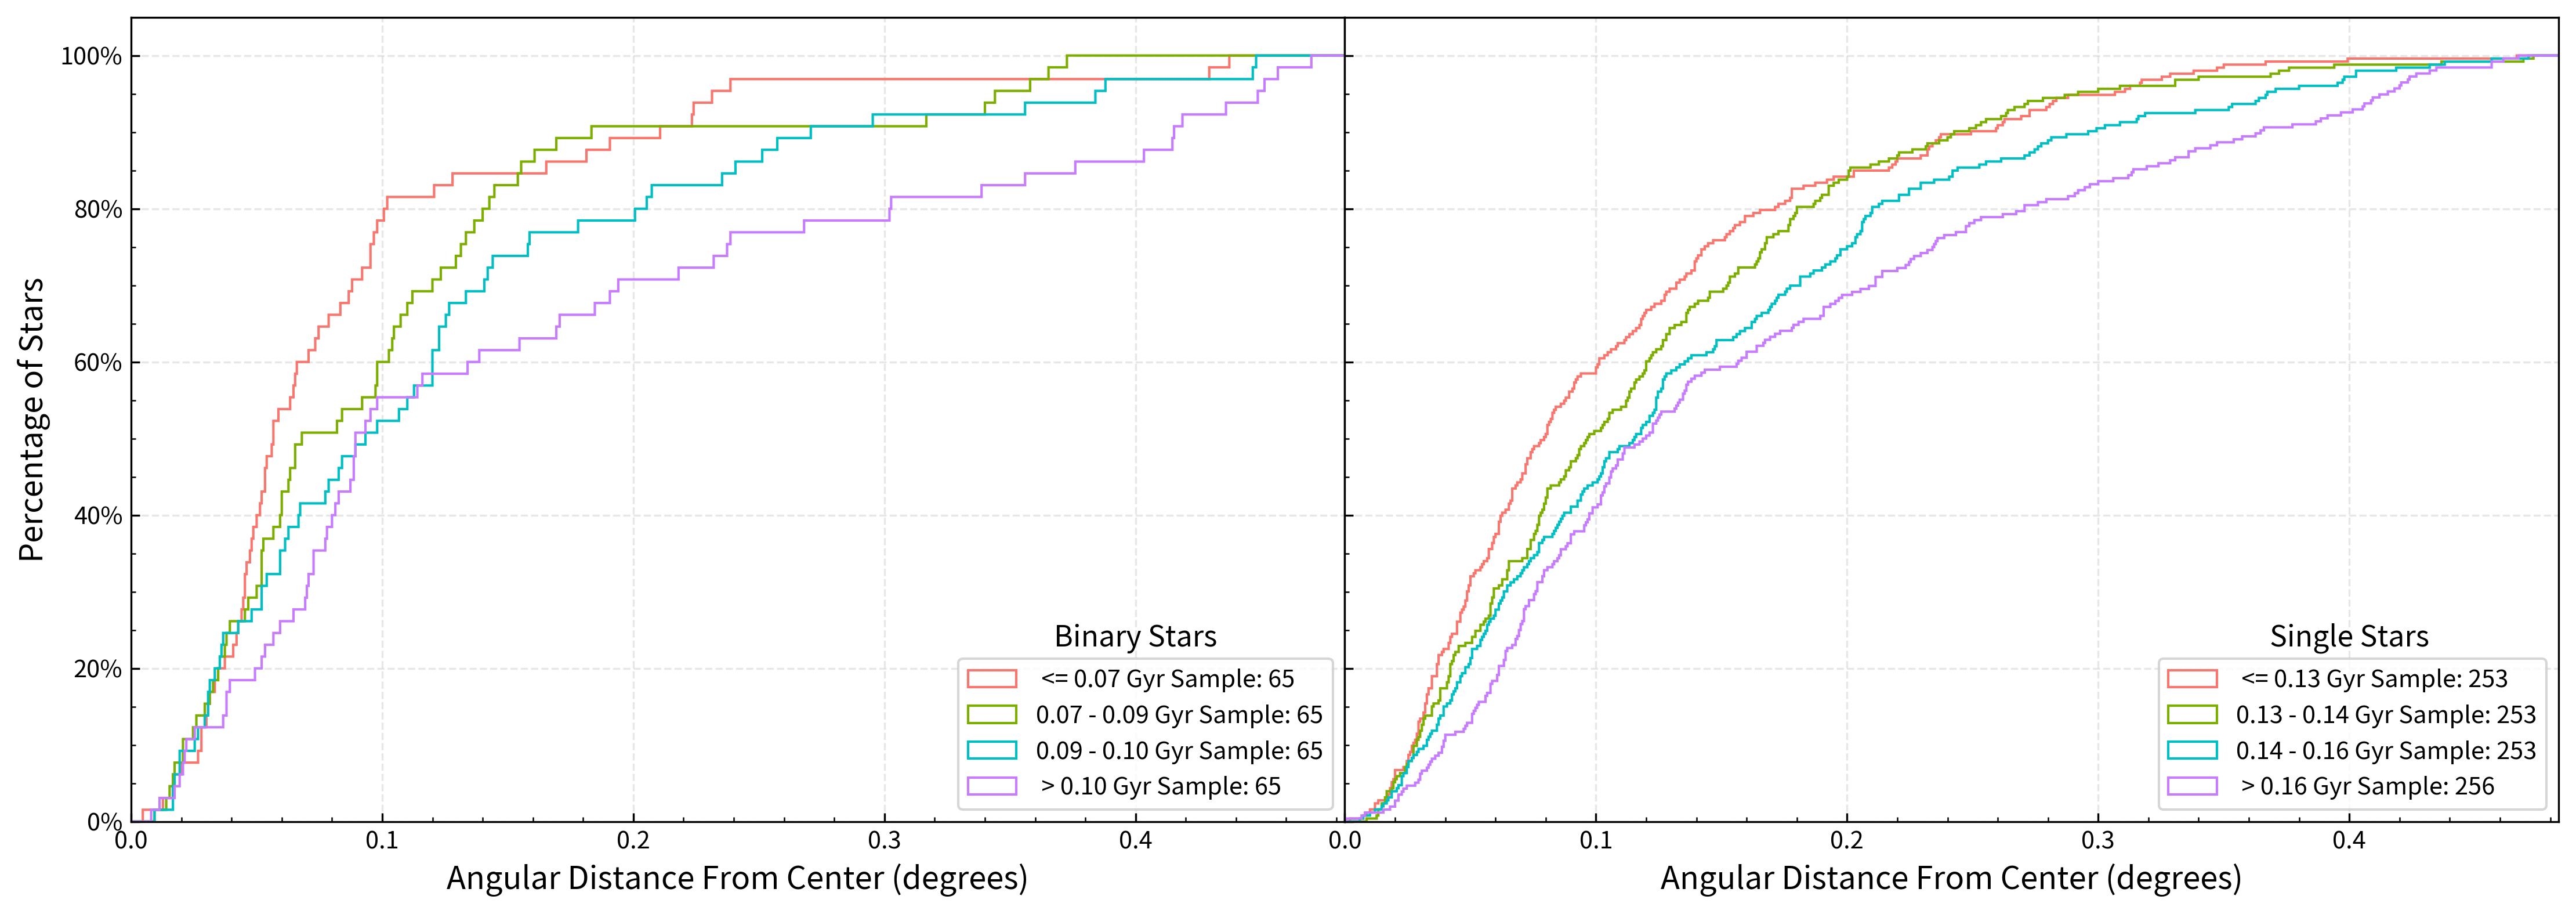

In [145]:
#SUBPLOTS TEST

fig, axs = plt.subplots(1, 2, figsize=(18, 6), facecolor='w', dpi=300, sharey=True)

# Plot the first subplot
axs[0].hist(binarybin1, cumulative=True, density=True, range=(0, 1), histtype="step", bins=1500, color=blue, label=f' <= {binary_endpoints[0]/1e9:.2f} Gyr Sample: {binarybin1Sample}')
axs[0].hist(binarybin2, cumulative=True, density=True, range=(0, 1), histtype="step", bins=1500, color=purple, label=f'{binary_endpoints[0]/1e9:.2f} - {binary_endpoints[1]/1e9:.2f} Gyr Sample: {binarybin2Sample}')
axs[0].hist(binarybin3, cumulative=True, density=True, range=(0, 1), histtype="step", bins=1500, color=pink, label=f'{binary_endpoints[1]/1e9:.2f} - {binary_endpoints[2]/1e9:.2f} Gyr Sample: {binarybin3Sample}')
axs[0].hist(binarybin4, cumulative=True, density=True, range=(0, 1), histtype="step", bins=1500, color=gold, label=f' > {binary_endpoints[2]/1e9:.2f} Gyr Sample: {binarybin4Sample}')
axs[0].set_xlabel("Angular Distance From Center (degrees)", fontsize=13)
axs[0].set_ylabel("Percentage of Stars", fontsize=13)
#axs[0].set_title("CDF of NGC 6819 Binaries by $t_{seg}$", fontsize=15)
axs[0].legend(loc='lower right')
axs[0].annotate(text='Binary Stars',  xy=(.4,.22), xytext=(.4,.22), ha='center', va='bottom', size=12)
axs[0].grid(linestyle='--', alpha=0.3)
axs[0].yaxis.set_major_formatter(PercentFormatter(1))
axs[0].minorticks_on()
axs[0].tick_params(which='both', direction="in")
axs[0].set_xlim(0, ten_core_radii)

# Plot the second subplot (identical to the first)
axs[1].hist(singlebin1, cumulative=True, density=True, range=(0, 1), histtype="step", bins=1500, color=blue, label=f' <= {single_endpoints[0]/1e9:.2f} Gyr Sample: {singlebin1Sample}')
axs[1].hist(singlebin2, cumulative=True, density=True, range=(0, 1), histtype="step", bins=1500, color=purple, label=f'{single_endpoints[0]/1e9:.2f} - {single_endpoints[1]/1e9:.2f} Gyr Sample: {singlebin2Sample}')
axs[1].hist(singlebin3, cumulative=True, density=True, range=(0, 1), histtype="step", bins=1500, color=pink, label=f'{single_endpoints[1]/1e9:.2f} - {single_endpoints[2]/1e9:.2f} Gyr Sample: {singlebin3Sample}')
axs[1].hist(singlebin4, cumulative=True, density=True, range=(0, 1), histtype="step", bins=1500, color=gold, label=f' > {single_endpoints[2]/1e9:.2f} Gyr Sample: {singlebin4Sample}')
axs[1].set_xlabel("Angular Distance From Center (degrees)", fontsize=13)
#axs[1].set_ylabel("Percentage of Single Stars", fontsize=13)
#axs[1].set_title("CDF of NGC 6819 Single stars by $t_{seg}$", fontsize=15)
axs[1].legend(loc='lower right')
axs[1].annotate(text='Single Stars',  xy=(.4,.22), xytext=(.4,.22), ha='center', va='bottom', size=12)
axs[1].grid(linestyle='--', alpha=0.3)
#axs[1].yaxis.set_major_formatter(PercentFormatter(1))
axs[1].minorticks_on()
axs[1].tick_params(which='both', direction="in")
axs[1].set_xlim(0, ten_core_radii)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0)

plt.savefig('tsegCDFs.pdf',dpi=300, bbox_inches='tight')

In [146]:
# #t_seg bins COMPARISON
# f,ax = plt.subplots(figsize=(9,6), facecolor='w',dpi=300)

# singlemin_tseg = np.min(singlePhot_copy['t_seg'])
# singlemax_tseg = np.max(singlePhot_copy['t_seg'])
# print(f'Single Min: {singlemin_tseg/1e9:.3f} Gyr', f'\nSingle Max: {singlemax_tseg/1e9:.3f} Gyr')
# binarymin_tseg = np.min(binaryPhot_copy['t_seg'])
# binarymax_tseg = np.max(binaryPhot_copy['t_seg'])
# print(f'Binary Min: {binarymin_tseg/1e9:.3f} Gyr', f'\nBinary Max: {binarymax_tseg/1e9:.3f} Gyr')

# ax.hist(binarybin1, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#648fff', label=f'<= {binary_endpoints[0]/1e9:.2f} Gyr Binary Sample: {binarybin1Sample}')
# ax.hist(singlebin1, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#648fff', ls='--', label=f'<= {single_endpoints[0]/1e9:.2f} Gyr Single Sample: {singlebin1Sample}')

# # ax.hist(binarybin2, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#785ef0', label=f'{binary_endpoints[0]/1e9:.2f} - {binary_endpoints[1]/1e9:.2f} Gyr Binary Sample: {binarybin2Sample}')
# # ax.hist(singlebin2, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#785ef0', ls='--',label=f'{single_endpoints[0]/1e9:.2f} - {single_endpoints[1]/1e9:.2f} Gyr Single Sample: {singlebin2Sample}')

# # ax.hist(binarybin3, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#dc267f', label=f'{binary_endpoints[1]/1e9:.2f} - {binary_endpoints[2]/1e9:.2f} Gyr Binary Sample: {binarybin3Sample}')
# # ax.hist(singlebin3, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#dc267f', ls='--', label=f'{single_endpoints[1]/1e9:.2f} - {single_endpoints[2]/1e9:.2f} Gyr Single Sample: {singlebin3Sample}')

# ax.hist(binarybin4, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='orange', label=f' > {binary_endpoints[2]/1e9:.2f} Gyr Binary Sample: {binarybin4Sample}')
# ax.hist(singlebin4, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='orange', ls='--', label=f' > {single_endpoints[2]/1e9:.2f} Gyr Single Sample: {singlebin4Sample}')


# ks_result, twoside_pvalue1 = ks_2samp(binarybin1,singlebin1)
# print(twoside_pvalue1)
# ks_result, twoside_pvalue2 = ks_2samp(binarybin2,singlebin2)
# print(twoside_pvalue2)
# ks_result, twoside_pvalue3 = ks_2samp(binarybin3,singlebin3)
# print(twoside_pvalue3)
# ks_result, twoside_pvalue4 = ks_2samp(binarybin4,singlebin4)
# print(twoside_pvalue4)

# plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
# plt.ylabel("Percentage of Stars", fontsize=13)
# plt.title("CDF of NGC 6819 Single & Binary Stars by $t_{seg}$", fontsize=15)
# plt.legend(loc='lower right')
# plt.grid(linestyle='--', alpha=0.3)

# from matplotlib.ticker import PercentFormatter
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# ax.yaxis.get_ticklocs(minor=True)
# ax.minorticks_on()
# ax.tick_params(which='both', direction="in")
# ax.set_xlim(0,.634)

# print(f"Binary: {binary_endpoints[2]/1e9:.3f} Gyr", f"Single: {single_endpoints[2]/1e9:.3f} Gyr")
# plt.show()


## Misc

In [147]:
# f, ax = plt.subplots(figsize=(5,8))
# photMems = phot.loc[phot['member']]
# photBinary = phot.loc[phot['binary']]
# ax.plot(phot['g_ps'] - phot['i_ps'], phot['g_ps'],'.', color='gray')
# ax.plot(photMems['g_ps'] - photMems['i_ps'], photMems['g_ps'],'.', color='magenta')
# ax.plot(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'],'.', color='blue')
# ax.set_xlim(0, 3)
# ax.set_ylim(23, 12)

In [148]:
# r = photBinary['qMedian']
# f, ax = plt.subplots(figsize=(8,15))

# ax.set_xlabel('G_BP - G_RP',fontsize=18)
# ax.set_ylabel('G',fontsize=18)
# #plot phot and cluster members
# #plt.scatter(originalGaia['G_BP'] - originalGaia['G_RP'], originalGaia['G'],s=15, color='lightgray',label='Sample From Gaia')
# plt.scatter(phot['G_BP'] - phot['G_RP'], phot['G'],s=30, color='#707070',label='Gaia Cluster Members')
# plt.scatter(photMems['G_BP'] - photMems['G_RP'], photMems['G'],s=20, color='#000000',label='Gaia+BASE9 Cluster Members')
# #plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], color='#000000')
# ax.set_xlim(0, 3)
# ax.set_ylim(21,10)


# #plot colorbar
# plt.scatter(photBinary['G_BP'] - photBinary['G_RP'], photBinary['G'], s=35, c=r, cmap=plt.cm.get_cmap("viridis"),edgecolors= "black",linewidth=0.75,label='Identified Binaries')

# plt.colorbar(label="Mass Ratio", orientation="horizontal",pad=0,location='top')


# #overplot isochrone
# photfile = ph
# cmdfile = r"/Users/Claire/Documents/Code/current/ANNACRNN/NGC6819_FINAL/NGC_6819_final.ms"
# mag       = 'G'
# color     = 'G_BP-G_RP'.split('-')
# header   = np.loadtxt(cmdfile,max_rows=1,dtype=str)
# yplot     = np.where(header == mag)[0][0]
# color1    = np.where(header == color[0])[0][0]
# color2    = np.where(header == color[1])[0][0]
# data = np.loadtxt(cmdfile,skiprows=1)
# ymag    = data[:,yplot]
# color   = data[:,color1] - data[:,color2]
# plt.plot(color, ymag, color='red',linewidth=1,label='Isochrone')
# plt.legend(loc="upper right",edgecolor='black')
# #plt.show()
# plt.savefig('MegaCMD1.png',dpi=300, bbox_inches="tight")
    


In [149]:
print(len(photBinary['qMedian']), len(binaryPhot_copy['qMedian']))


288 260


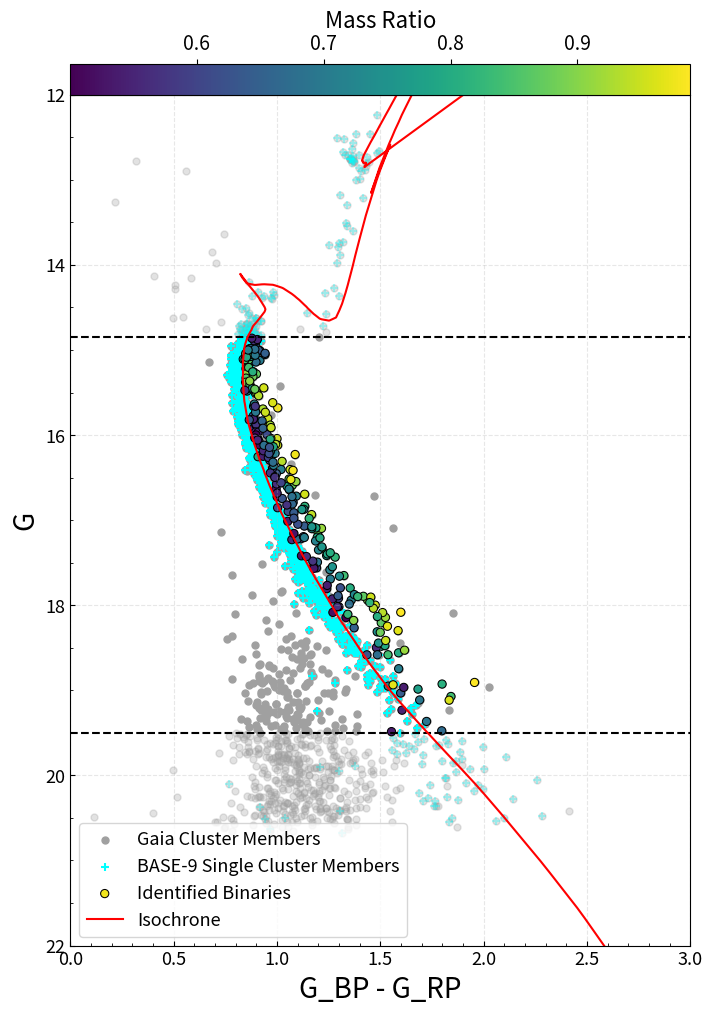

In [150]:
r = binaryPhot_copy['qMedian']
f, ax = plt.subplots(figsize=(8,13), facecolor='w')
ax.set_xlabel('G_BP - G_RP',fontsize=20)
ax.set_ylabel('G',fontsize=20)
plt.grid(linestyle='--', alpha=0.3)
#plot phot and cluster members
#plt.scatter(originalGaia['G_BP'] - originalGaia["G_RP"], originalGaia["G"], s=5, color="#D3D3D3", label="Full Sample")
plt.scatter(phot['G_BP'] - phot['G_RP'], phot['G'],s=25, color='#A0A0A0', label="Gaia Cluster Members")
plt.scatter(phot_CMDcut['G_BP'] - phot_CMDcut['G_RP'], phot_CMDcut['G'],s=25, color='#A0A0A0', alpha=.3)

plt.scatter(photMems['G_BP'] - photMems['G_RP'], photMems['G'],s=35, color='cyan', marker="+", label="BASE-9 Single Cluster Members")
plt.scatter(phot_CMDcutMems['G_BP'] - phot_CMDcutMems['G_RP'], phot_CMDcutMems['G'],s=35, color='cyan', marker="+", alpha=.3)

#plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], color='#000000')


ax.set_xlim(0, 3)
ax.set_ylim(22, 12)
#plot colorbar
plt.scatter(binaryPhot_copy['G_BP'] - binaryPhot_copy['G_RP'], binaryPhot_copy['G'], s=35, c=r, cmap=plt.cm.get_cmap("viridis"),edgecolors= "black",linewidth=0.75, label="Identified Binaries")
cbar = plt.colorbar(orientation="horizontal",pad=0,location='top')
plt.axhline(y=upperlim, color='black', ls='--')
plt.axhline(y=lowerlim, color='black', ls='--')
cbar.set_label("Mass Ratio", fontsize=16)
tick_font_size = 14
cbar.ax.tick_params(labelsize=tick_font_size)

cmdfile =r"/Users/Claire/Documents/Code/current/ANNACRNN/NGC6819_FINAL/NGC_6819_final.ms"
mag     = "G"
color     = "G_BP-G_RP".split('-')

header = np.loadtxt(cmdfile,max_rows=1,dtype=str)
yplot     = np.where(header == mag)[0][0]
color1    = np.where(header == color[0])[0][0]
color2    = np.where(header == color[1])[0][0]
data = np.loadtxt(cmdfile,skiprows=1)
ymag    = data[:,yplot]
color   = data[:,color1] - data[:,color2]
plt.plot(color, ymag, color='red', label="Isochrone")
ax.legend(fontsize=13,loc="lower left")
#ax.tick_params(which = 'major', direction = 'in', labelsize = 14)
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in", labelsize=13)
#plt.savefig('cmdWithMassRatio.png', dpi=300)

plt.show()

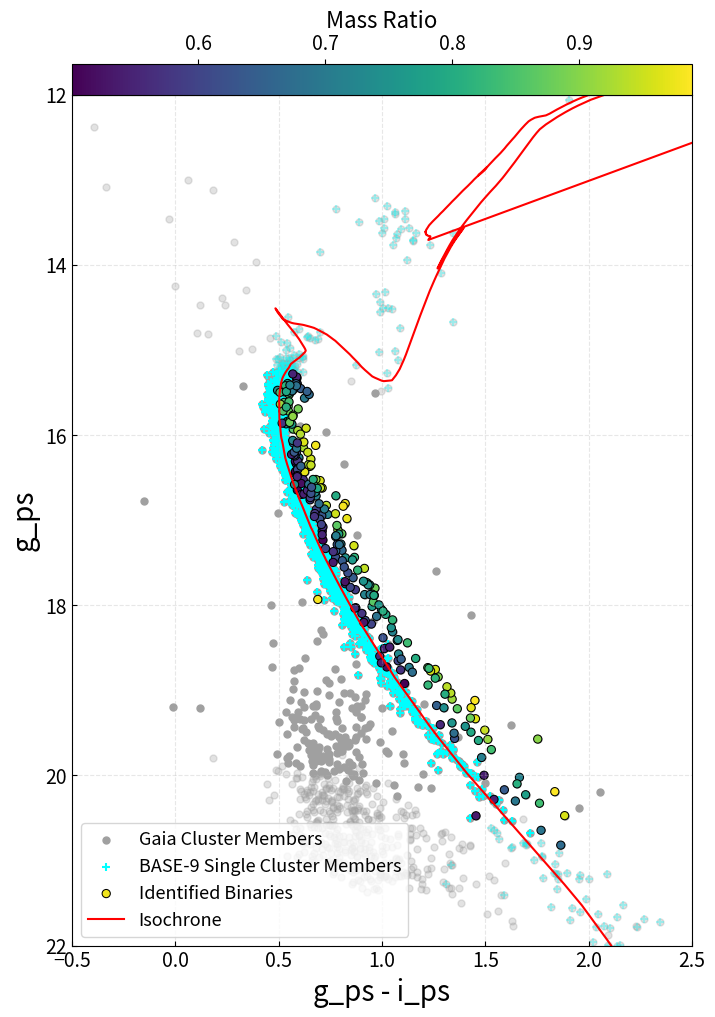

In [151]:
r = binaryPhot_copy['qMedian']
f, ax = plt.subplots(figsize=(8,13), facecolor='w')
ax.set_xlabel('g_ps - i_ps',fontsize=20)
ax.set_ylabel('g_ps',fontsize=20)
plt.grid(linestyle='--', alpha=0.3)
#plot phot and cluster members
#plt.scatter(originalGaia['G_BP'] - originalGaia["G_RP"], originalGaia["G"], s=5, color="#D3D3D3", label="Full Sample")
plt.scatter(phot['g_ps'] - phot['i_ps'], phot['g_ps'],s=25, color='#A0A0A0', label="Gaia Cluster Members")
plt.scatter(phot_CMDcut['g_ps'] - phot_CMDcut['i_ps'], phot_CMDcut['g_ps'],s=25, color='#A0A0A0', alpha=.3)

plt.scatter(photMems['g_ps'] - photMems['i_ps'], photMems['g_ps'],s=35, color='cyan', marker="+", label="BASE-9 Single Cluster Members")
plt.scatter(phot_CMDcutMems['g_ps'] - phot_CMDcutMems['i_ps'], phot_CMDcutMems['g_ps'],s=35, color='cyan', marker="+", alpha=.3)

#plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], color='#000000')


ax.set_xlim(-.5, 2.5)
ax.set_ylim(22, 12)
#plot colorbar
plt.scatter(binaryPhot_copy['g_ps'] - binaryPhot_copy['i_ps'], binaryPhot_copy['g_ps'], s=35, c=r, cmap=plt.cm.get_cmap("viridis"),edgecolors= "black",linewidth=0.75, label="Identified Binaries")
cbar = plt.colorbar(orientation="horizontal",pad=0,location='top')
cbar.set_label("Mass Ratio", fontsize=16)
tick_font_size = 14
cbar.ax.tick_params(labelsize=tick_font_size)

cmdfile =r"/Users/Claire/Documents/Code/current/ANNACRNN/NGC6819_FINAL/NGC_6819_final.ms"
mag     = "g_ps"
color     = "g_ps-i_ps".split('-')

header = np.loadtxt(cmdfile,max_rows=1,dtype=str)
yplot     = np.where(header == mag)[0][0]
color1    = np.where(header == color[0])[0][0]
color2    = np.where(header == color[1])[0][0]
data = np.loadtxt(cmdfile,skiprows=1)
ymag    = data[:,yplot]
color   = data[:,color1] - data[:,color2]
plt.plot(color, ymag, color='red', label="Isochrone")
ax.legend(fontsize=13,loc="lower left")
ax.tick_params(which = 'major', direction = 'in', labelsize = 14)
plt.savefig('cmdWithMassRatio.png', dpi=300)

plt.show()

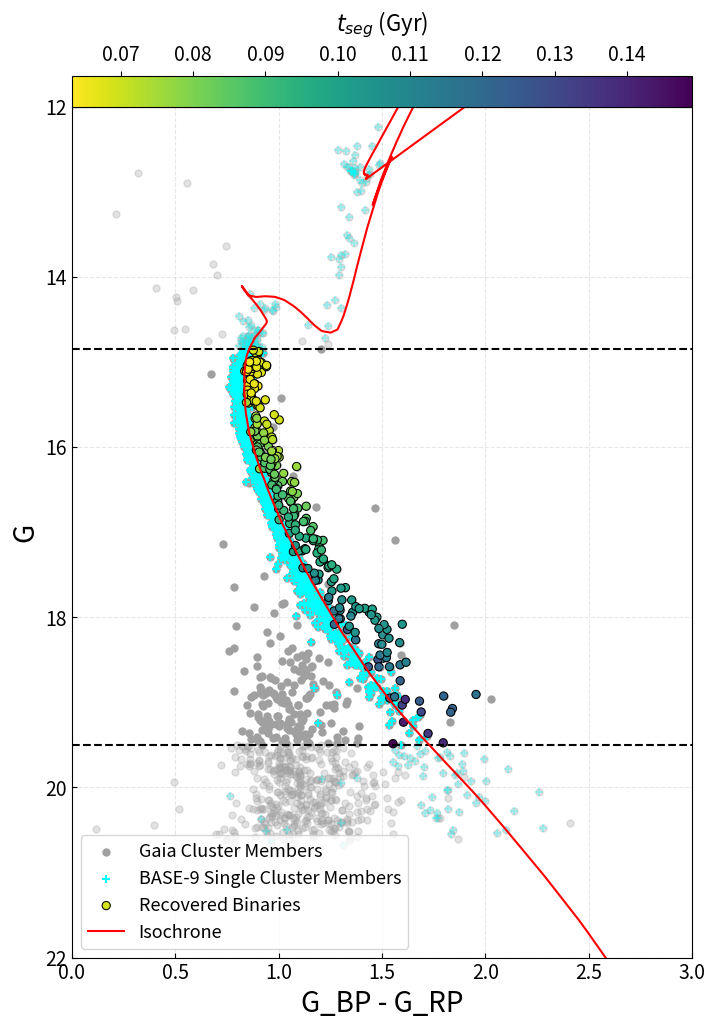

In [152]:
r = binaryPhot_copy['t_seg']/1e9
f, ax = plt.subplots(figsize=(8,13), facecolor='w')
ax.set_xlabel('G_BP - G_RP',fontsize=20)
ax.set_ylabel('G',fontsize=20)
plt.grid(linestyle='--', alpha=0.3)
#plot phot and cluster members
#plt.scatter(originalGaia['G_BP'] - originalGaia["G_RP"], originalGaia["G"], s=5, color="#D3D3D3", label="Full Sample")
# plt.scatter(phot['G_BP'] - phot['G_RP'], phot['G'],s=25, color='#A0A0A0', label="Gaia Cluster Members") # check tseg was calculated
# plt.scatter(photMems_copy['G_BP'] - photMems_copy['G_RP'], photMems_copy['G'],s=35, color='cyan', marker="+", label="BASE-9 Single Cluster Members")

plt.scatter(phot['G_BP'] - phot['G_RP'], phot['G'],s=25, color='#A0A0A0', label="Gaia Cluster Members")
plt.scatter(phot_CMDcut['G_BP'] - phot_CMDcut['G_RP'], phot_CMDcut['G'],s=25, color='#A0A0A0', alpha=.3)

plt.scatter(photMems['G_BP'] - photMems['G_RP'], photMems['G'],s=35, color='cyan', marker="+", label="BASE-9 Single Cluster Members")
plt.scatter(phot_CMDcutMems['G_BP'] - phot_CMDcutMems['G_RP'], phot_CMDcutMems['G'],s=35, color='cyan', marker="+", alpha=.3)

#plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], color='#000000')

ax.set_xlim(0, 3)
ax.set_ylim(22, 12)
#plot colorbar
plt.scatter(binaryPhot_copy['G_BP'] - binaryPhot_copy['G_RP'], binaryPhot_copy['G'], s=35, c=r, cmap=plt.cm.get_cmap("viridis").reversed(),edgecolors= "black",linewidth=0.75, label="Recovered Binaries")
cbar = plt.colorbar(orientation="horizontal",pad=0,location='top')
plt.axhline(y=upperlim, color='black', ls='--')
plt.axhline(y=lowerlim, color='black', ls='--')
cbar.set_label("$t_{seg}$ (Gyr)", fontsize=16, labelpad=10)
tick_font_size = 14
cbar.ax.tick_params(labelsize=tick_font_size)

cmdfile =r"/Users/Claire/Documents/Code/current/ANNACRNN/NGC6819_FINAL/NGC_6819_final.ms"
mag     = "G"
color     = "G_BP-G_RP".split('-')

header = np.loadtxt(cmdfile,max_rows=1,dtype=str)
yplot     = np.where(header == mag)[0][0]
color1    = np.where(header == color[0])[0][0]
color2    = np.where(header == color[1])[0][0]
data = np.loadtxt(cmdfile,skiprows=1)
ymag    = data[:,yplot]
color   = data[:,color1] - data[:,color2]
plt.plot(color, ymag, color='red', label="Isochrone")
ax.legend(fontsize=13,loc="lower left")
ax.tick_params(which = 'major', direction = 'in', labelsize = 14)
#plt.savefig('cmdWithtSegregation.png', dpi=300)

plt.show()

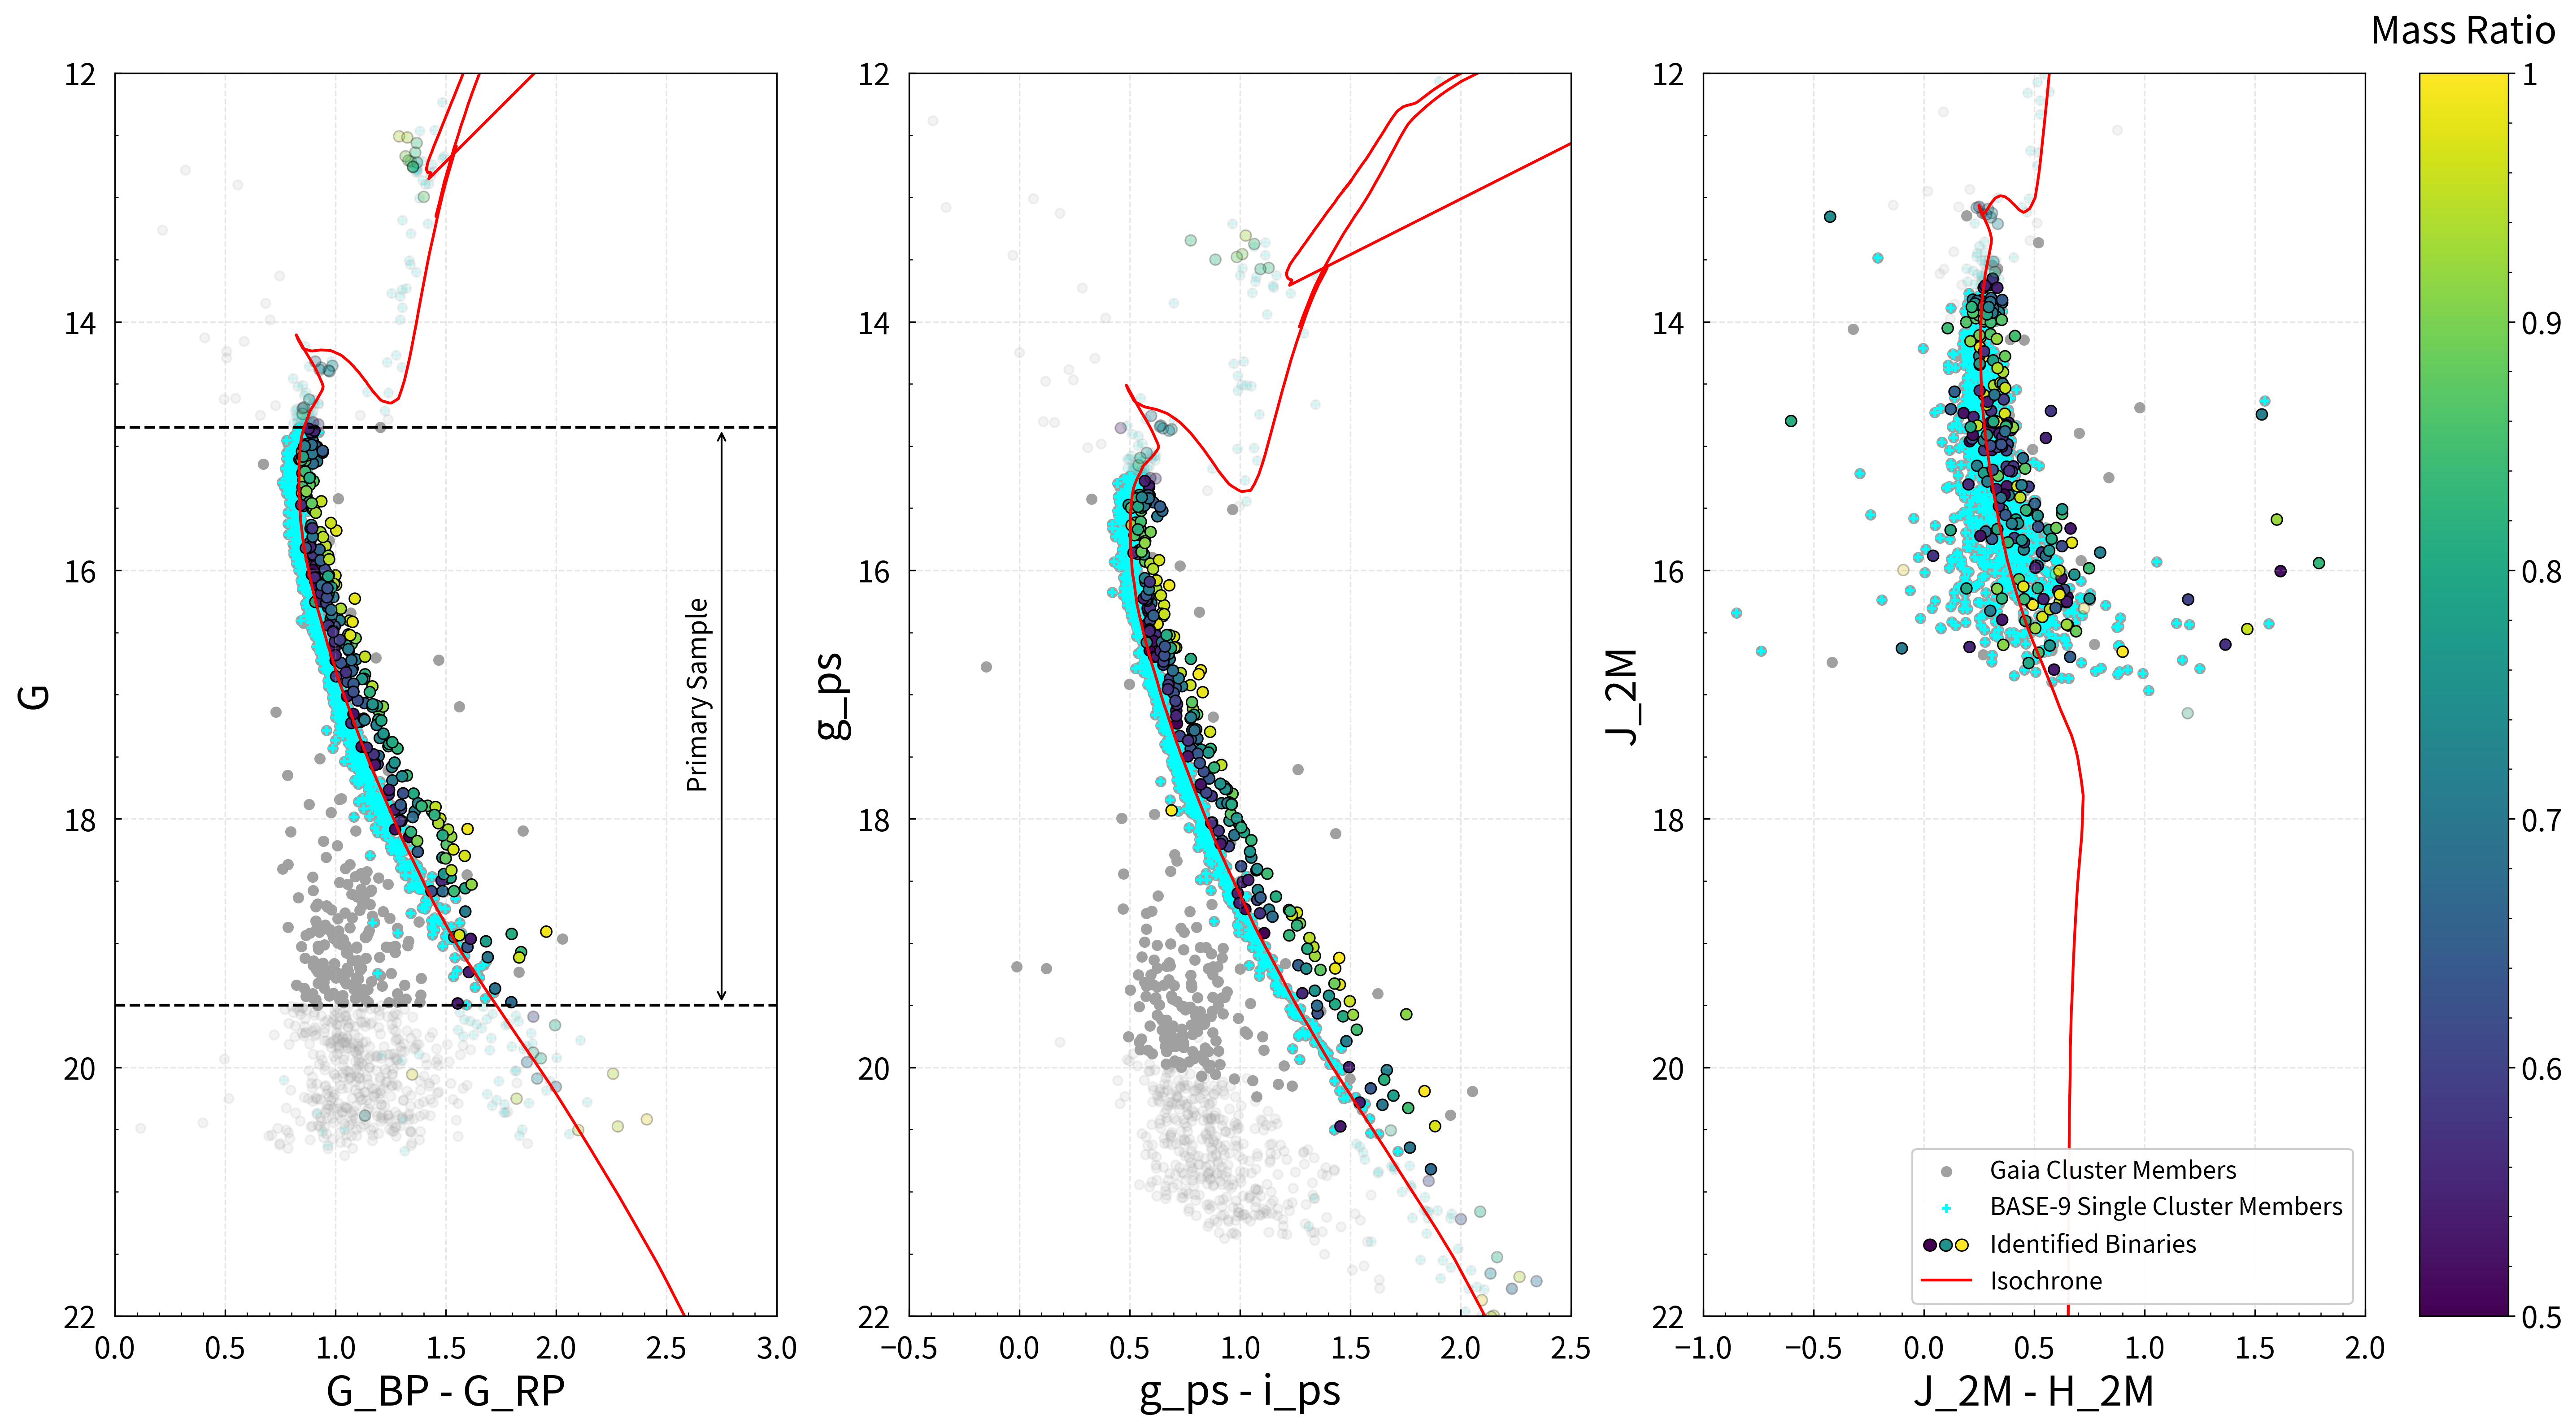

In [153]:
fig, axs = plt.subplots(1, 3, figsize=(26, 12),dpi=300, facecolor='w')
from mpl_toolkits.axes_grid1 import make_axes_locatable
r = binaryPhot_copy['qMedian']
divider= make_axes_locatable(axs[0])
axs[0].set_xlabel('G_BP - G_RP',fontsize=22)
axs[0].set_ylabel('G',fontsize=22)
axs[0].grid(linestyle='--', alpha=0.3)
axs[0].set_xlim(0, 3)
axs[0].set_ylim(22, 12)

axs[0].scatter(phot['G_BP'] - phot['G_RP'], phot['G'],s=25, color='#A0A0A0', label="Gaia Cluster Members")
axs[0].scatter(phot_CMDcut['G_BP'] - phot_CMDcut['G_RP'], phot_CMDcut['G'],s=25, color='#A0A0A0', alpha=.125)

axs[0].scatter(photMems['G_BP'] - photMems['G_RP'], photMems['G'],s=25, color='cyan', marker="+", label="BASE-9 Single Cluster Members")
axs[0].scatter(phot_CMDcutMems['G_BP'] - phot_CMDcutMems['G_RP'], phot_CMDcutMems['G'],s=25, color='cyan', marker="+", alpha=.125)

#plot colorbar
im = axs[0].scatter(binaryPhot_copy['G_BP'] - binaryPhot_copy['G_RP'], binaryPhot_copy['G'], s=35, c=r, cmap=plt.cm.get_cmap("viridis"),vmin=0.5, vmax=1.0,edgecolors= "black",linewidth=0.75, label="Identified Binaries")
axs[0].scatter(phot_CMDcutBinary['G_BP'] - phot_CMDcutBinary['G_RP'], phot_CMDcutBinary['G'], s=35, c=phot_CMDcutBinary['qMedian'], cmap=plt.cm.get_cmap("viridis"),edgecolors= "black",linewidth=0.75, alpha=.25)

cb= fig.colorbar(im, ax=(axs), pad=.02, ticks=[0.5,0.6,0.7,0.8,0.9,1], aspect=14)
cb.ax.set_yticklabels(['0.5','0.6','0.7','0.8','0.9', '1'])
#cbar1 = plt.colorbar(orientation="horizontal",pad=0,location='top')
axs[0].axhline(y=upperlim, color='black', ls='--')
axs[0].axhline(y=lowerlim, color='black', ls='--')


# Add the annotation with the arrow
axs[0].annotate('', xy=(2.75, lowerlim), xytext=(2.75, upperlim),
             arrowprops=dict(arrowstyle='<->'),
             annotation_clip=False)
axs[0].annotate('Primary Sample', xy=(2.65, 18), xytext=(2.65, 17), fontsize=14,
                rotation=90, ha='center', va='center')

#cb.set_label("Mass Ratio", fontsize=20, rotation='horizontal', loc='top', labelpad=4)
cb.ax.set_title('Mass Ratio', fontsize=20, y=1.015)
tick_font_size = 16
cb.ax.tick_params(labelsize=tick_font_size)
cb.ax.minorticks_on()

cmdfile =r"/Users/Claire/Documents/Code/current/ANNACRNN/NGC6819_FINAL/NGC_6819_final.ms"
mag     = "G"
color     = "G_BP-G_RP".split('-')

header = np.loadtxt(cmdfile,max_rows=1,dtype=str)
yplot     = np.where(header == mag)[0][0]
color1    = np.where(header == color[0])[0][0]
color2    = np.where(header == color[1])[0][0]
data = np.loadtxt(cmdfile,skiprows=1)
ymag    = data[:,yplot]
color   = data[:,color1] - data[:,color2]
axs[0].plot(color, ymag, color='red', label="Isochrone")
#axs[0].legend(fontsize=13,loc="lower left")
#ax.tick_params(which = 'major', direction = 'in', labelsize = 14)
axs[0].yaxis.get_ticklocs(minor=True)
axs[0].minorticks_on()
axs[0].tick_params(which='both', direction="in", labelsize=13)
#plt.savefig('cmdWithMassRatio.png', dpi=300)

#Panstarrs
r = binaryPhot_copy['qMedian']
axs[1].set_xlabel('g_ps - i_ps',fontsize=22)
axs[1].set_ylabel('g_ps',fontsize=22)
axs[1].grid(linestyle='--', alpha=0.3)

axs[1].scatter(phot['g_ps'] - phot['i_ps'], phot['g_ps'],s=25, color='#A0A0A0', label="Gaia Cluster Members")
axs[1].scatter(phot_CMDcut['g_ps'] - phot_CMDcut['i_ps'], phot_CMDcut['g_ps'],s=25, color='#A0A0A0', alpha=.125)

axs[1].scatter(photMems['g_ps'] - photMems['i_ps'], photMems['g_ps'],s=25, color='cyan', marker="+", label="BASE-9 Single Cluster Members")
axs[1].scatter(phot_CMDcutMems['g_ps'] - phot_CMDcutMems['i_ps'], phot_CMDcutMems['g_ps'],s=25, color='cyan', marker="+", alpha=.125)

axs[1].set_xlim(-.5, 2.5)
axs[1].set_ylim(22, 12)
#plot colorbar
axs[1].scatter(binaryPhot_copy['g_ps'] - binaryPhot_copy['i_ps'], binaryPhot_copy['g_ps'], s=35, c=r, cmap=plt.cm.get_cmap("viridis"),edgecolors= "black",linewidth=0.75, label="Identified Binaries")
axs[1].scatter(phot_CMDcutBinary['g_ps'] - phot_CMDcutBinary['i_ps'], phot_CMDcutBinary['g_ps'], s=35, c=phot_CMDcutBinary['qMedian'], cmap=plt.cm.get_cmap("viridis"),edgecolors= "black",linewidth=0.75, alpha=.25)

cmdfile =r"/Users/Claire/Documents/Code/current/ANNACRNN/NGC6819_FINAL/NGC_6819_final.ms"
mag     = "g_ps"
color     = "g_ps-i_ps".split('-')

header = np.loadtxt(cmdfile,max_rows=1,dtype=str)
yplot     = np.where(header == mag)[0][0]
color1    = np.where(header == color[0])[0][0]
color2    = np.where(header == color[1])[0][0]
data = np.loadtxt(cmdfile,skiprows=1)
ymag    = data[:,yplot]
color   = data[:,color1] - data[:,color2]
axs[1].plot(color, ymag, color='red', label="Isochrone")
#axs[1].legend(fontsize=13,loc="lower left")
axs[1].tick_params(which = 'major', direction = 'in', labelsize = 14)


#2MASS
r = binaryPhot_copy['qMedian']
axs[2].set_xlabel('J_2M - H_2M',fontsize=22)
axs[2].set_ylabel('J_2M',fontsize=22)
axs[2].grid(linestyle='--', alpha=0.3)

axs[2].scatter(phot['J_2M'] - phot['H_2M'], phot['J_2M'],s=25, color='#A0A0A0', label="Gaia Cluster Members")
axs[2].scatter(phot_CMDcut['J_2M'] - phot_CMDcut['H_2M'], phot_CMDcut['J_2M'],s=25, color='#A0A0A0', alpha=.125)

axs[2].scatter(photMems['J_2M'] - photMems['H_2M'], photMems['J_2M'],s=25, color='cyan', marker="+", label="BASE-9 Single Cluster Members")
axs[2].scatter(phot_CMDcutMems['J_2M'] - phot_CMDcutMems['H_2M'], phot_CMDcutMems['J_2M'],s=25, color='cyan', marker="+", alpha=.125)

axs[2].set_xlim(-1, 2)
axs[2].set_ylim(22, 12)

#plot colorbar
axs[2].scatter(binaryPhot_copy['J_2M'] - binaryPhot_copy['H_2M'], binaryPhot_copy['J_2M'], s=35, c=r, cmap=plt.cm.get_cmap("viridis"),edgecolors= "black",linewidth=0.75, label="Identified Binaries")
axs[2].scatter(phot_CMDcutBinary['J_2M'] - phot_CMDcutBinary['H_2M'], phot_CMDcutBinary['J_2M'], s=35, c=phot_CMDcutBinary['qMedian'], cmap=plt.cm.get_cmap("viridis"),edgecolors= "black",linewidth=0.75, alpha=.25)


cmdfile =r"/Users/Claire/Documents/Code/current/ANNACRNN/NGC6819_FINAL/NGC_6819_final.ms"
mag     = "J_2M"
color     = "J_2M-H_2M".split('-')

header = np.loadtxt(cmdfile,max_rows=1,dtype=str)
yplot     = np.where(header == mag)[0][0]
color1    = np.where(header == color[0])[0][0]
color2    = np.where(header == color[1])[0][0]
data = np.loadtxt(cmdfile,skiprows=1)
ymag    = data[:,yplot]
color   = data[:,color1] - data[:,color2]
axs[2].plot(color, ymag, color='red', label="Isochrone")
axs[2].legend(fontsize=13,loc="lower right", framealpha=0.96)
axs[2].tick_params(which = 'major', direction = 'in', labelsize = 14)

for ax in axs:
    ax.tick_params(axis='both', which='major', direction='in', labelsize=16, pad=10)
    ax.yaxis.get_ticklocs(minor=True)
    ax.minorticks_on()
    ax.tick_params(which = 'both', direction = 'in')
    
from matplotlib.patches import Ellipse
# Create the ellipse patch
width = 0.057
height = 0.095
padding = 0.015
ellipse_patch = Ellipse((0.1-width-padding, 21.43), width, height, facecolor='#440154', edgecolor='black', linewidth=.75, zorder=10)
ellipse_patch2 = Ellipse((0.1, 21.43), width, height, facecolor='#21918c', edgecolor='black', linewidth=.75, zorder=10)
ellipse_patch3 = Ellipse((0.1+width+padding, 21.43), width, height, facecolor='#fde725', edgecolor='black', linewidth=.75, zorder=10)
# Add the ellipse patch to the axes
axs[2].add_patch(ellipse_patch)
axs[2].add_patch(ellipse_patch2)
axs[2].add_patch(ellipse_patch3)

plt.savefig('tripleCMD.pdf',dpi=300, bbox_inches="tight")

In [154]:
#recall the following:
# upperlim=14.85
# lowerlim=19.5
# phot_CMDcut = phot.loc[(phot['G'] > lowerlim) | (phot['G'] < upperlim)]
# phot_CMDcutMems = phot_CMDcut[phot_CMDcut['member'] == True]

#I just noticed I never printed binaries outside of the cuts, need to do that

# Gaia cluster members
testdf2 = phot_CMDcut.loc[phot_CMDcut['G'] > lowerlim]  # take all G > lowerlim members
num_entries = testdf2.shape[0]
min_g_ps = np.min(testdf2['g_ps'])
median_g_ps = np.nanmedian(testdf2['g_ps'])
print(f"# gaia cluster members with G > {lowerlim:.1f}:  {num_entries}")  # number of entries
print(f'"highest" or "brightest" mag g_ps of those members: {min_g_ps:.2f}')  # print the "highest/brightest" mag g_ps of those members
print(f'median mag g_ps of those members: {median_g_ps:.2f}\n')  # print the median mag g_ps of those members

# BASE-9 single cluster members
testdf = phot_CMDcutMems.loc[phot_CMDcutMems['G'] > lowerlim]  # take all G > lowerlim members
num_entries = testdf.shape[0]
min_g_ps = np.min(testdf['g_ps'])
median_g_ps = np.nanmedian(testdf['g_ps'])
print(f"# BASE-9 single cluster members with G > {lowerlim:.1f}:  {num_entries}")  # number of entries
print(f'"highest" or "brightest" mag g_ps of those members: {min_g_ps:.2f}')  # print the "highest/brightest" mag g_ps of those members
print(f'median mag g_ps of those members: {median_g_ps:.2f}')  # print the median mag g_ps of those members


# gaia cluster members with G > 19.5:  487
"highest" or "brightest" mag g_ps of those members: 19.76
median mag g_ps of those members: 20.74

# BASE-9 single cluster members with G > 19.5:  72
"highest" or "brightest" mag g_ps of those members: 20.56
median mag g_ps of those members: 21.21


In [155]:
#recall the cuts are at 14.85 mag and 19.5 mag
# upperlim=14.85
# lowerlim=19.5

# BASE-9 binaries
testdf3 = binaryPhot_copy.loc[binaryPhot_copy['g_ps'] > lowerlim]  # take all g_ps > 19.5 binaries that weren't cut
num_entries = testdf3.shape[0]
min_G = np.min(testdf3['G'])
max_G = np.max(testdf3['G'])
median_G = np.nanmedian(testdf3['G'])

print(f"# of BASE-9 binaries with g_ps > {lowerlim:.1f}:  {num_entries}")  # number of entries
print(f'"highest" or "brightest" mag G of those members: {min_G:.2f}')  # print the "highest/brightest" mag G of those members
print(f'"lowest" or "dimmest" mag G of those members: {max_G:.2f}')  # print the "lowest/dimmest" mag G of those members
print(f'median mag G of those members: {median_G:.2f}')  # print the median mag G of those members

# of BASE-9 binaries with g_ps > 19.5:  20
"highest" or "brightest" mag G of those members: 18.18
"lowest" or "dimmest" mag G of those members: 19.49
median mag G of those members: 18.96
